## Problem Statement

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores. 

In [1]:
## Importing all necessary libraries
%matplotlib inline

import pandas as pd
pd.get_option("display.max_columns")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000) 
pd.set_option('display.width', 1000)
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen #Johansen Cointegration test

# EDA 

### Analysing train.csv Data

In [2]:
#Uploading train data
df_train = pd.read_csv('train.csv')
df_train.head(20)

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0       1          5  2015-07-31   5263        555     1      1            0              1
1       2          5  2015-07-31   6064        625     1      1            0              1
2       3          5  2015-07-31   8314        821     1      1            0              1
3       4          5  2015-07-31  13995       1498     1      1            0              1
4       5          5  2015-07-31   4822        559     1      1            0              1
5       6          5  2015-07-31   5651        589     1      1            0              1
6       7          5  2015-07-31  15344       1414     1      1            0              1
7       8          5  2015-07-31   8492        833     1      1            0              1
8       9          5  2015-07-31   8565        687     1      1            0              1
9      10          5  2015-07-31   7185        681     1      1            0              1
10     11          5  2015-07-31  10457       1236     1      1            0              1
11     12          5  2015-07-31   8959        962     1      1            0              1
12     13          5  2015-07-31   8821        568     1      1            0              0
13     14          5  2015-07-31   6544        710     1      1            0              1
14     15          5  2015-07-31   9191        766     1      1            0              1
15     16          5  2015-07-31  10231        979     1      1            0              1
16     17          5  2015-07-31   8430        946     1      1            0              1
17     18          5  2015-07-31  10071        936     1      1            0              1
18     19          5  2015-07-31   8234        718     1      1            0              1
19     20          5  2015-07-31   9593        974     1      1            0              0

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
df_train['Store'].unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

In [5]:
df_train['DayOfWeek'].unique()

array([5, 4, 3, 2, 1, 7, 6], dtype=int64)

In [6]:
df_train['Promo'].unique()

array([1, 0], dtype=int64)

In [7]:
df_train['SchoolHoliday'].unique()

array([1, 0], dtype=int64)

In [8]:
df_train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
df_train.describe()

Store     DayOfWeek         Sales     Customers          Open         Promo  SchoolHoliday
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01  4.857586e-01   3.830564e-01
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.000000e+00
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00  0.000000e+00   0.000000e+00
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00  1.000000e+00   0.000000e+00
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00  1.000000e+00   1.000000e+00

#### As seen above there are no null values found in the columns of train data

In [10]:
#Uploading store data
df_store = pd.read_csv('store.csv')
df_store.head(20)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval
0       1         c          a               1270.0                        9.0                    2008.0       0              NaN              NaN               NaN
1       2         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0   Jan,Apr,Jul,Oct
2       3         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0   Jan,Apr,Jul,Oct
3       4         c          c                620.0                        9.0                    2009.0       0              NaN              NaN               NaN
4       5         a          a              29910.0                        4.0                    2015.0       0              NaN              NaN               NaN
5       6         a          a                310.0                       12.0                    2013.0       0              NaN              NaN               NaN
6       7         a          c              24000.0                        4.0                    2013.0       0              NaN              NaN               NaN
7       8         a          a               7520.0                       10.0                    2014.0       0              NaN              NaN               NaN
8       9         a          c               2030.0                        8.0                    2000.0       0              NaN              NaN               NaN
9      10         a          a               3160.0                        9.0                    2009.0       0              NaN              NaN               NaN
10     11         a          c                960.0                       11.0                    2011.0       1              1.0           2012.0   Jan,Apr,Jul,Oct
11     12         a          c               1070.0                        NaN                       NaN       1             13.0           2010.0   Jan,Apr,Jul,Oct
12     13         d          a                310.0                        NaN                       NaN       1             45.0           2009.0   Feb,May,Aug,Nov
13     14         a          a               1300.0                        3.0                    2014.0       1             40.0           2011.0   Jan,Apr,Jul,Oct
14     15         d          c               4110.0                        3.0                    2010.0       1             14.0           2011.0   Jan,Apr,Jul,Oct
15     16         a          c               3270.0                        NaN                       NaN       0              NaN              NaN               NaN
16     17         a          a                 50.0                       12.0                    2005.0       1             26.0           2010.0   Jan,Apr,Jul,Oct
17     18         d          c              13840.0                        6.0                    2010.0       1             14.0           2012.0   Jan,Apr,Jul,Oct
18     19         a          c               3240.0                        NaN                       NaN       1             22.0           2011.0  Mar,Jun,Sept,Dec
19     20         d          a               2340.0                        5.0                    2009.0       1             40.0           2014.0   Jan,Apr,Jul,Oct

In [11]:
#Checking  Promo2 attributes wherever the values are NaN
len(df_store[df_store['Promo2']==0 & df_store['Promo2SinceYear'].isnull() & df_store['Promo2SinceWeek'].isnull() & df_store['PromoInterval'].isnull()])

544

In [12]:
len(df_store[df_store['Promo2']==0])

544

In [13]:
#As whenever Promo2 value is 0 Promo2SinceWeek,Promo2SinceYear and PromoInterval values are NaN 
#thus these can be substituted with 0
df_store['Promo2SinceYear'].fillna(0, inplace=True)
df_store['Promo2SinceWeek'].fillna(0, inplace=True)
df_store['PromoInterval'].fillna(0, inplace=True)

In [14]:
len(df_store)

1115

In [15]:
df_store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0                0
1      2         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0  Jan,Apr,Jul,Oct
2      3         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0  Jan,Apr,Jul,Oct
3      4         c          c                620.0                        9.0                    2009.0       0              0.0              0.0                0
4      5         a          a              29910.0                        4.0                    2015.0       0              0.0              0.0                0

In [16]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [17]:
#Checking the records where Competition Distance is Null
df_store[df_store['CompetitionDistance'].isnull()]

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
290    291         d          a                  NaN                        NaN                       NaN       0              0.0              0.0                0
621    622         a          c                  NaN                        NaN                       NaN       0              0.0              0.0                0
878    879         d          a                  NaN                        NaN                       NaN       1              5.0           2013.0  Feb,May,Aug,Nov

In [18]:
## Filling the competitor distance by a nedian distance value
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace=True)

In [19]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [20]:
df_store[df_store['CompetitionDistance'].isnull()]

Empty DataFrame
Columns: [Store, StoreType, Assortment, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval]
Index: []

In [21]:
df_store['CompetitionOpenSinceMonth'].median()

8.0

In [22]:
df_store['CompetitionOpenSinceMonth'].fillna(df_store['CompetitionOpenSinceMonth'].median(), inplace=True)

In [23]:
df_store['CompetitionOpenSinceYear'].median()

2010.0

In [24]:
df_store['CompetitionOpenSinceYear'].fillna(df_store['CompetitionOpenSinceYear'].median(), inplace=True)

In [25]:
#Cpnverting the Competition parameters to int
df_store['CompetitionOpenSinceMonth']=df_store['CompetitionOpenSinceMonth'].astype(int)
df_store['CompetitionOpenSinceYear']=df_store['CompetitionOpenSinceYear'].astype(int)

In [26]:
# opened stores with zero sales
no_sales = df_train[(df_train.Open != 0) & (df_train.Sales == 0)]
print("In total: ", no_sales.shape)
no_sales.head(5)

In total:  (54, 9)


Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
86825     971          5  2015-05-15      0          0     1      0            0              1
142278    674          4  2015-03-26      0          0     1      0            0              0
196938    699          4  2015-02-05      0          0     1      1            0              0
322053    708          3  2014-10-01      0          0     1      1            0              0
330176    357          1  2014-09-22      0          0     1      0            0              0

In [27]:
##Merging both the data frames
df = pd.merge(df_train, df_store, how = 'inner', on = 'Store')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  int32  
 13  CompetitionO

In [29]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

print("In total: ", df.shape)



Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 18)


In [30]:
df['StateHoliday'].unique()

array(['0', 0, 'a', 'b', 'c'], dtype=object)

In [31]:
#replacing 0 and '0' values to o which will imply NO state holiday
df.loc[df.StateHoliday == '0', "StateHoliday"] = "o"

In [32]:
df.loc[df.StateHoliday == 0, "StateHoliday"] = "o"

In [33]:
df['StateHoliday'].unique()

array(['o', 'a', 'b', 'c'], dtype=object)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Open                       844338 non-null  int64  
 6   Promo                      844338 non-null  int64  
 7   StateHoliday               844338 non-null  object 
 8   SchoolHoliday              844338 non-null  int64  
 9   StoreType                  844338 non-null  object 
 10  Assortment                 844338 non-null  object 
 11  CompetitionDistance        844338 non-null  float64
 12  CompetitionOpenSinceMonth  844338 non-null  int32  
 13  CompetitionOpenSinceYear   8

In [35]:
df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval
0      1          5  2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0              0.0              0.0             0
1      1          4  2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0              0.0              0.0             0
2      1          3  2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0              0.0              0.0             0
3      1          2  2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0              0.0              0.0             0
4      1          1  2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0              0.0              0.0             0

In [36]:
df['Promo2SinceWeek']=df['Promo2SinceWeek'].astype(int)
df['Promo2SinceYear']=df['Promo2SinceYear'].astype(int)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Open                       844338 non-null  int64  
 6   Promo                      844338 non-null  int64  
 7   StateHoliday               844338 non-null  object 
 8   SchoolHoliday              844338 non-null  int64  
 9   StoreType                  844338 non-null  object 
 10  Assortment                 844338 non-null  object 
 11  CompetitionDistance        844338 non-null  float64
 12  CompetitionOpenSinceMonth  844338 non-null  int32  
 13  CompetitionOpenSinceYear   8

In [38]:
#Separating the Date column into Separate columns of Year Month and Date
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Year'] = pd.DatetimeIndex(df['Date']).year

Text(0.5, 1.0, 'Competitions getting opened in respective months')

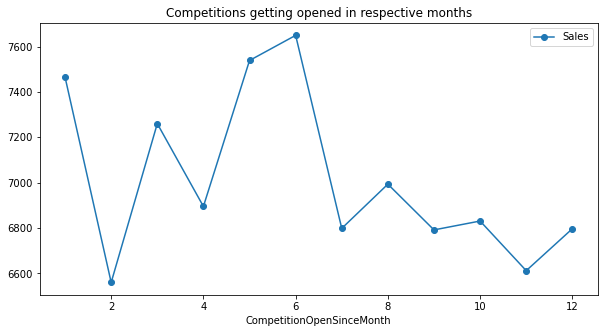

In [39]:
axis = df.groupby('CompetitionOpenSinceMonth')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Competitions getting opened in respective months')

In [40]:
#From the above graph we can see the most competitions opens in the month 6 

Text(0.5, 1.0, 'Competitions getting opened in respective Years')

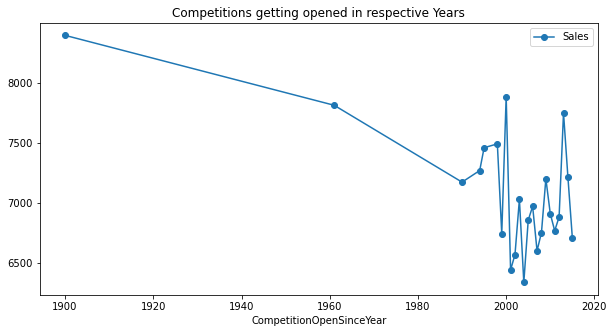

In [41]:
axis = df.groupby('CompetitionOpenSinceYear')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Competitions getting opened in respective Years')

#### The above graphs shows on an average most of the competetors open at the month of June and during the years 2000 and 2017

In [42]:
df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year
0      1          5  2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015
1      1          4  2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015
2      1          3  2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015
3      1          2  2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015
4      1          1  2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015

In [43]:
#Analyzing Sales as per the StoreTypes
df.groupby('StoreType')['Sales'].describe()

count          mean          std     min      25%     50%       75%      max
StoreType                                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   8406.00  41551.0
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0  13184.25  38722.0
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   8349.25  31448.0
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   8123.25  38037.0

In [44]:
df.groupby('StoreType')['Customers', 'Sales'].sum()

Customers       Sales
StoreType                       
a          363541431  3165334859
b           31465616   159231395
c           92129705   783221426
d          156904995  1765392943

Text(0.5, 1.0, 'Customers presence as per StoreType')

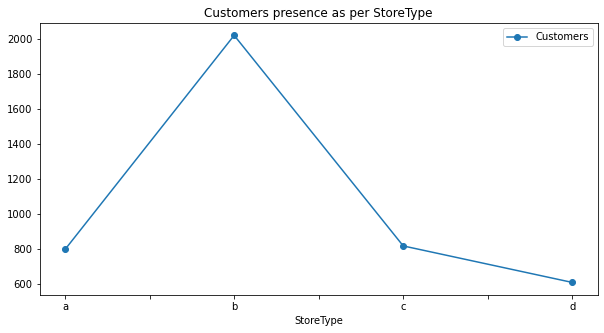

In [45]:
axis = df.groupby('StoreType')[['Customers']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Customers presence as per StoreType')

Text(0.5, 1.0, 'Promo2 starting weeks')

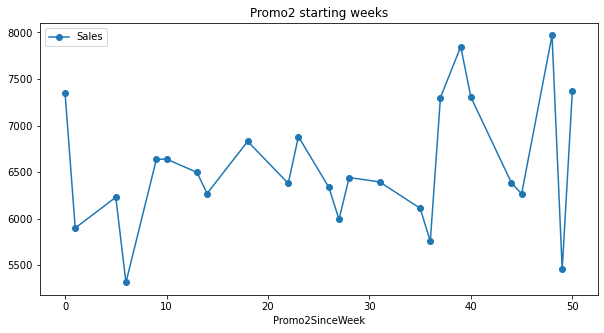

In [46]:
#Analysing Promo2SinceWeek  column

axis = df.groupby('Promo2SinceWeek')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Promo2 starting weeks')

Text(0.5, 1.0, 'Promo2 starting Years')

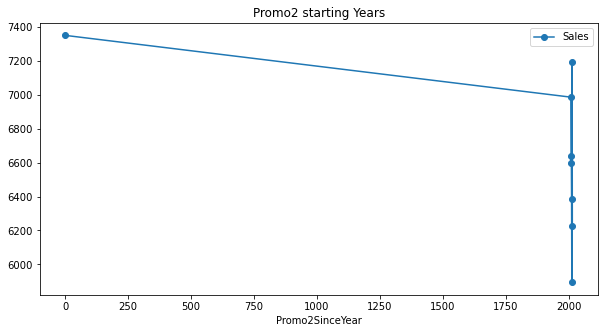

In [47]:
axis = df.groupby('Promo2SinceYear')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Promo2 starting Years')

In [48]:
df.max()

Store                              1115
DayOfWeek                             7
Date                         2015-07-31
Sales                             41551
Customers                          7388
Open                                  1
Promo                                 1
StateHoliday                          o
SchoolHoliday                         1
StoreType                             d
Assortment                            c
CompetitionDistance             75860.0
CompetitionOpenSinceMonth            12
CompetitionOpenSinceYear           2015
Promo2                                1
Promo2SinceWeek                      50
Promo2SinceYear                    2015
Day                                  31
Month                                12
Year                               2015
dtype: object

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Open                       844338 non-null  int64  
 6   Promo                      844338 non-null  int64  
 7   StateHoliday               844338 non-null  object 
 8   SchoolHoliday              844338 non-null  int64  
 9   StoreType                  844338 non-null  object 
 10  Assortment                 844338 non-null  object 
 11  CompetitionDistance        844338 non-null  float64
 12  CompetitionOpenSinceMonth  844338 non-null  int32  
 13  CompetitionOpenSinceYear   8

In [50]:
#Analysing Promo Interval
df['PromoInterval'].unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

Text(0.5, 1.0, 'Sales during various Promo intervals')

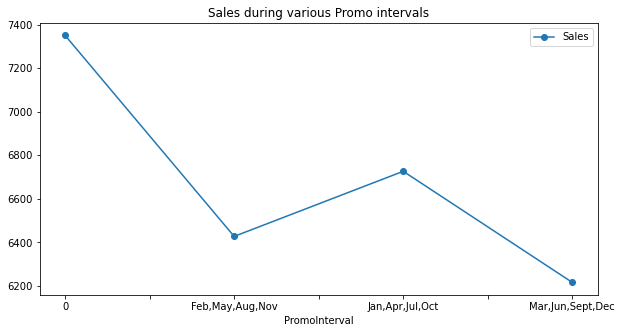

In [51]:
#Analysing Promo2SinceYear  column
axis = df.groupby('PromoInterval')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Sales during various Promo intervals')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Open                       844338 non-null  int64  
 6   Promo                      844338 non-null  int64  
 7   StateHoliday               844338 non-null  object 
 8   SchoolHoliday              844338 non-null  int64  
 9   StoreType                  844338 non-null  object 
 10  Assortment                 844338 non-null  object 
 11  CompetitionDistance        844338 non-null  float64
 12  CompetitionOpenSinceMonth  844338 non-null  int32  
 13  CompetitionOpenSinceYear   8

#### Now all the missing values are handles, lets handle the data types

In [53]:
#Changing Date column value into into Date type
df['Date'] = pd.to_datetime(df['Date'])

In [54]:
df['StateHoliday'].unique()

array(['o', 'a', 'b', 'c'], dtype=object)

Text(0.5, 1.0, 'Customers turnout during State Holidays')

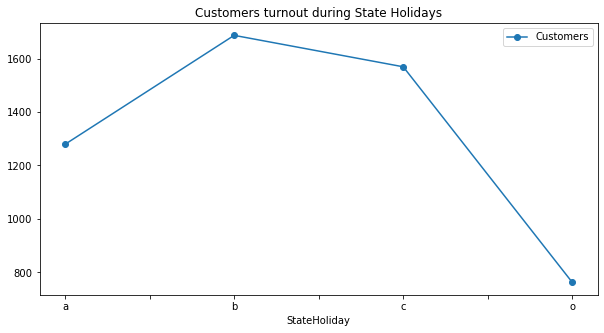

In [55]:
#Analysing Sales and State holiday
#Analysing Promo2SinceYear  column
axis = df.groupby('StateHoliday')[['Customers']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Customers turnout during State Holidays')

Text(0.5, 1.0, 'Sales during State Holidays')

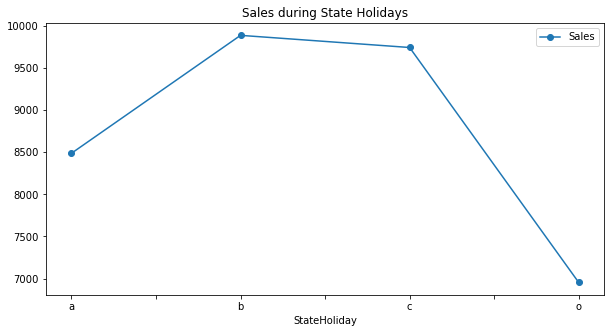

In [56]:
axis = df.groupby('StateHoliday')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Sales during State Holidays')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        844338 non-null  float64

In [58]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015

In [59]:
df_Promo2=df[df['Promo2']==1]
df_Promo2.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  Day  Month  Year
942      2          5 2015-07-31   6064        625     1      1            o              1         a          a                570.0                         11                      2007       1               13             2010  Jan,Apr,Jul,Oct   31      7  2015
943      2          4 2015-07-30   5567        601     1      1            o              1         a          a                570.0                         11                      2007       1               13             2010  Jan,Apr,Jul,Oct   30      7  2015
944      2          3 2015-07-29   6402        727     1      1            o              1         a          a                570.0                         11                      2007       1               13             2010  Jan,Apr,Jul,Oct   29      7  2015
945      2          2 2015-07-28   5671        646     1      1            o              1         a          a                570.0                         11                      2007       1               13             2010  Jan,Apr,Jul,Oct   28      7  2015
946      2          1 2015-07-27   6627        638     1      1            o              1         a          a                570.0                         11                      2007       1               13             2010  Jan,Apr,Jul,Oct   27      7  2015

In [60]:
df_chk1=df
#df=df_Promo2
#df=df_chk1

In [61]:
def findWeekDate(df,Promo2SinceYear,Promo2SinceWeek):
    import datetime
    from dateutil.relativedelta import relativedelta

 
    # constructing date
    date = datetime.date(Promo2SinceYear, 1, 1)
 
    res = date + relativedelta(weeks = +Promo2SinceWeek)
    
    return res


In [62]:
df['SalePerCustomer'] = df['Sales']/df['Customers']
#df['SalesPerStoreType']=df['Sales']

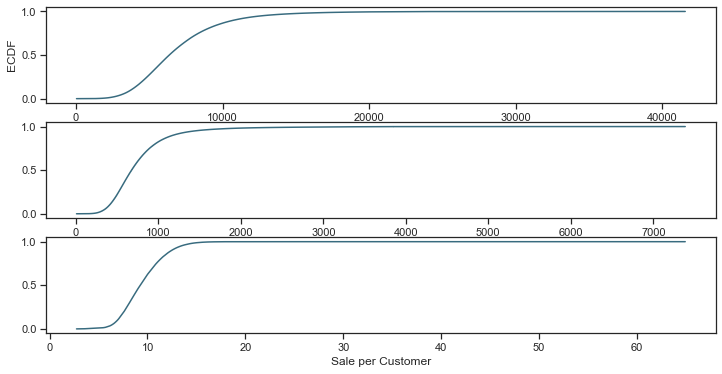

In [63]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(df['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(df['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(df['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

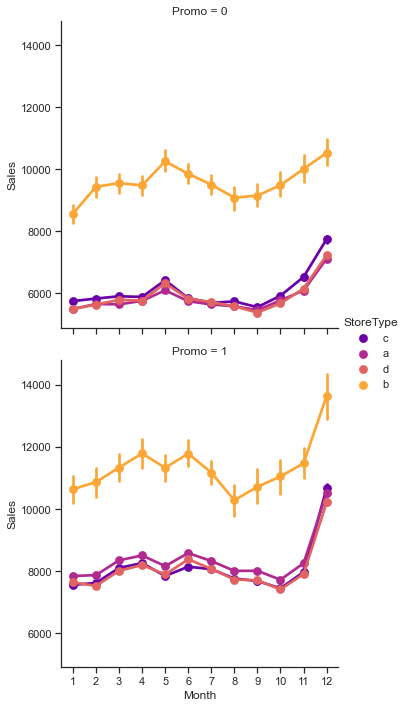

In [64]:
# Sales trends per Month
sns.factorplot(data = df, x = 'Month', y = "Sales", 
               palette = 'plasma',
               row = 'Promo',
               hue = 'StoreType',
               color = c)

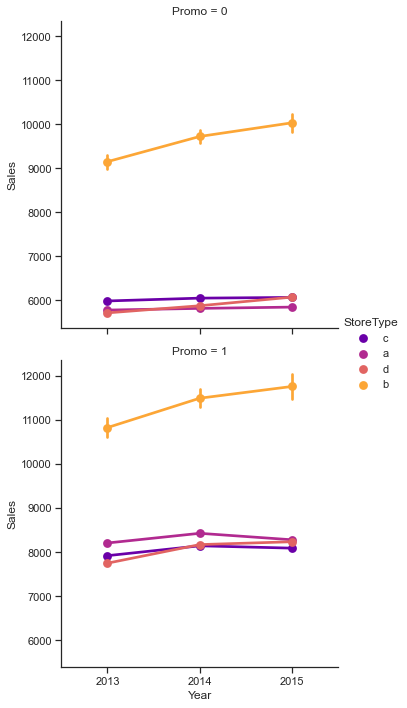

In [65]:
# Sales trends per Year
sns.factorplot(data = df, x = 'Year', y = "Sales", 
               palette = 'plasma',
               row = 'Promo',
               hue = 'StoreType',
               color = c)

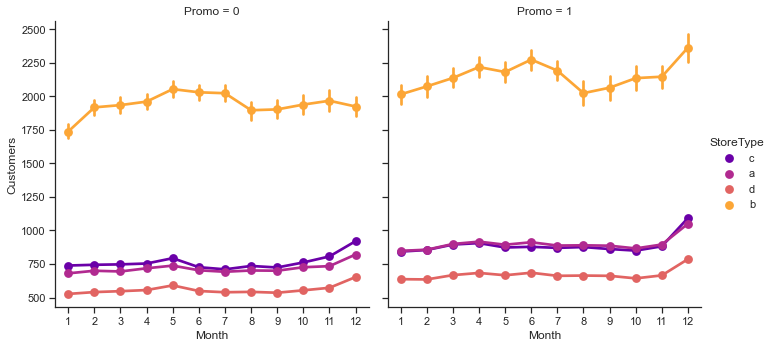

In [66]:
# sales trends
sns.factorplot(data = df, x = 'Month', y = "Customers", 
               palette = 'plasma',
               col = 'Promo',
               hue = 'StoreType',
               color = c) 

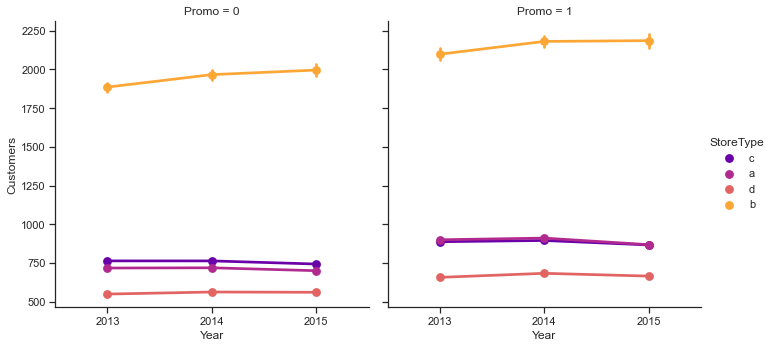

In [67]:
# Customers trends as per Store Type
sns.factorplot(data = df, x = 'Year', y = "Customers", 
               palette = 'plasma',
               col = 'Promo',
               hue = 'StoreType',
               color = c) 

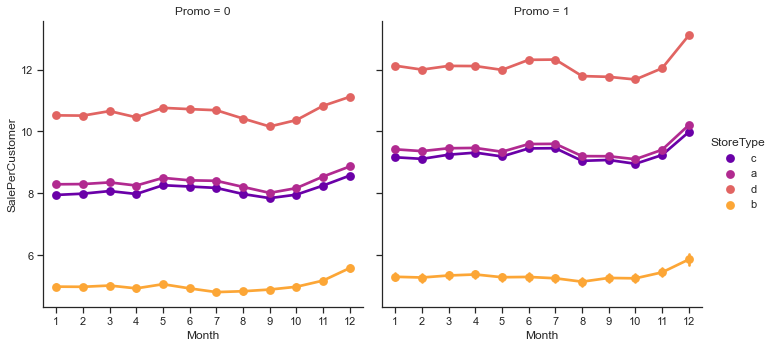

In [68]:
# sale per customer trends
sns.factorplot(data = df, x = 'Month', y = "SalePerCustomer", 
               palette = 'plasma',
               hue = 'StoreType',
               col = 'Promo', # per promo in the store in rows
               color = c) 

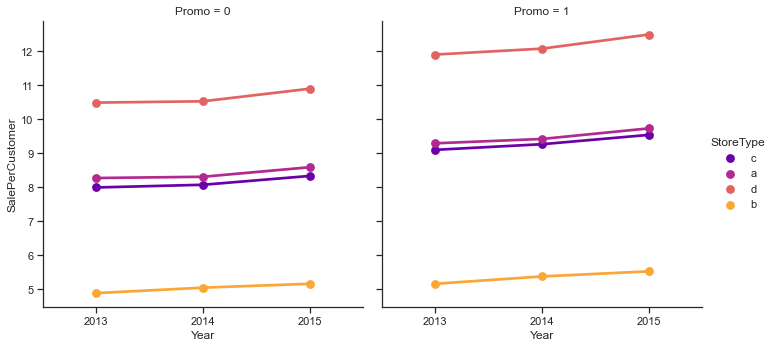

In [69]:
# sale per customer trends
sns.factorplot(data = df, x = 'Year', y = "SalePerCustomer", 
               palette = 'plasma',
               hue = 'StoreType',
               col = 'Promo', # per promo in the store in rows
               color = c)

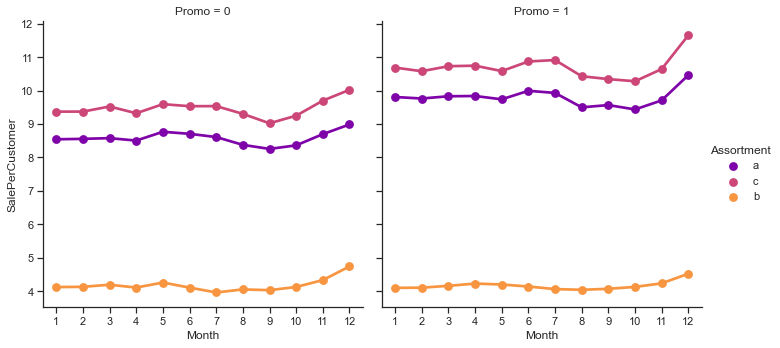

In [70]:
# sale per customer trends
sns.factorplot(data = df, x = 'Month', y = "SalePerCustomer", 
               palette = 'plasma',
               hue = 'Assortment',
               col = 'Promo', # per promo in the store in rows
               color = c)

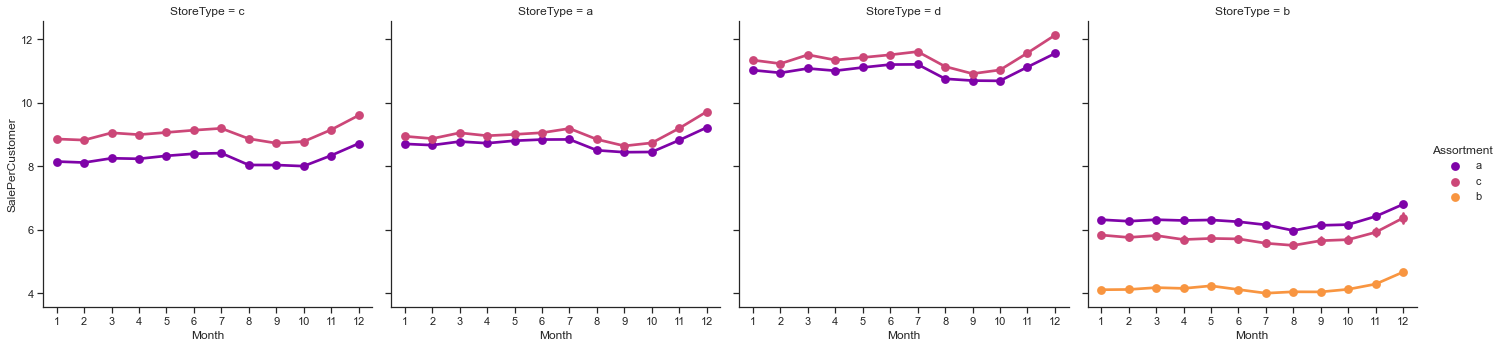

In [71]:
# sale per customer trends
sns.factorplot(data = df, x = 'Month', y = "SalePerCustomer", 
               palette = 'plasma',
               hue = 'Assortment',
               col = 'StoreType', # per promo in the store in rows
               color = c)

In [72]:
df['Assortment'].value_counts()

a    444875
c    391254
b      8209
Name: Assortment, dtype: int64

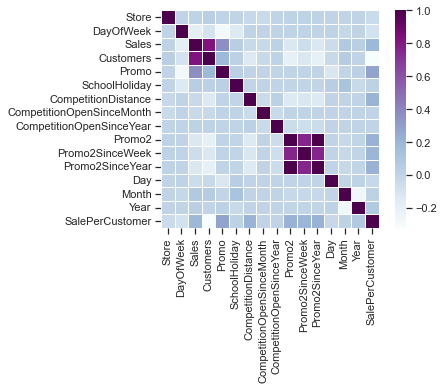

In [73]:
df_corr=df.drop('Open', axis = 1)
import seaborn as sns
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = df_corr.corr()

 # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, square = True, linewidths = .5, cmap = "BuPu")      
plt.show()

##### we have a strong positive correlation between the amount of Sales and Customers of a store.

We can also observe a positive correlation between the fact that the store had a running promotion (Promo equal to 1) and amount of Customers.

As soon as the store continues a consecutive promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap.

The same negative correlation is observed between the presence of the promotion in the store and the day of a week. 

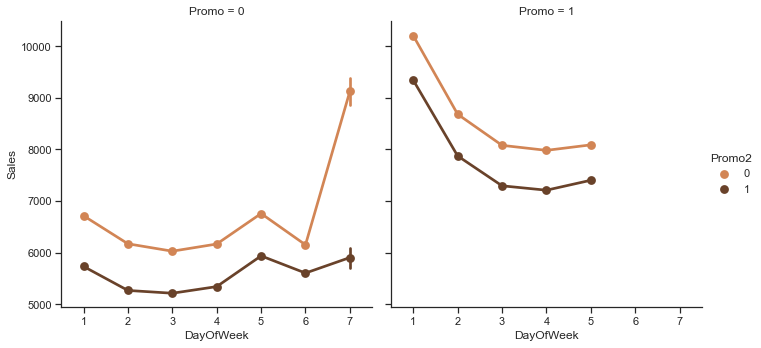

In [74]:
# sale per customer trends
sns.factorplot(data = df, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo',
               hue = 'Promo2',
               palette = 'copper_r') 

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        844338 non-null  float64

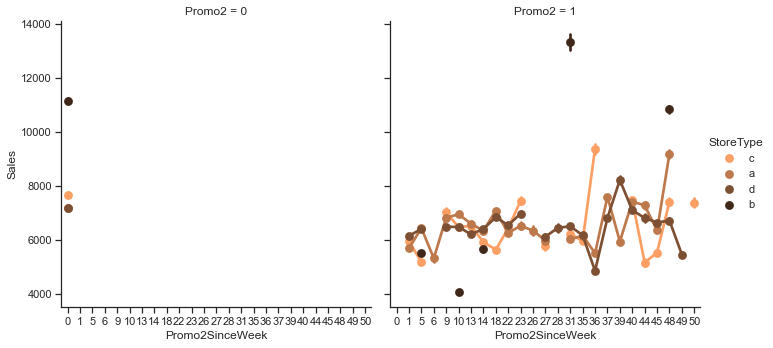

In [76]:
# sale per customer trends
sns.factorplot(data = df, x = 'Promo2SinceWeek', y = "Sales", 
               col = 'Promo2',
               hue = 'StoreType',
               palette = 'copper_r') 

#### In case of no promotion, both Promo and Promo2 are equal to 0,

On the contrary, stores that run the promotion tend to make most of the Sales on Sunday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).

Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above

In [77]:
from datetime import date

In [78]:
def findWeekOfYear(df,Year,Month,Day):
    #dt_tup = namedtuple('Date_Info', [Year, Month, Day])
    dt=date(Year,Month,Day)
    week_num=dt.isocalendar().week
    return week_num

In [79]:
dt=date(2005,6,12)
week_num=dt.isocalendar().week
print(week_num)    

23


In [80]:
df['WeekOfYear'] = df.apply(lambda row:findWeekOfYear(df,row.Year,row.Month,row.Day), axis = 1)

In [81]:
#competition open time (in months)
df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
# Promo open time
# to convert weeks into momths we divided by 4
df['PromoOpen'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4.0


In [82]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82   24187.75
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82   24187.75
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82   24187.75
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82   24187.75
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82   24187.75

In [83]:
#df.loc[df['CompetitionOpenSinceMonth'].isnull(), 'CompetitionOpen'] = 0
#df['CompetitionOpen'] = np.where(df['CompetitionOpenSinceMonth'].isnull, 0, df['CompetitionOpen'])

df['CompetitionOpen'].mask(df['CompetitionOpenSinceMonth'] == 0 ,0, inplace=True)


In [84]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82   24187.75
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82   24187.75
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82   24187.75
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82   24187.75
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82   24187.75

In [85]:

df['PromoOpen'].mask(df['Promo2'] == 0 ,0, inplace=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        844338 non-null  float64

In [87]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82        0.0
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82        0.0
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82        0.0
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82        0.0
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82        0.0

In [88]:
# average PromoOpen time and CompetitionOpen time per store type
df.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

Sales    Customers  PromoOpen  CompetitionOpen
StoreType                                                       
a           6925.697986   795.422370  10.958105        56.215394
b          10233.380141  2022.211825   3.717593        58.759512
c           6933.126425   815.538073  13.964386        57.506506
d           6822.300064   606.353935  14.827699        51.576795

In [89]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82        0.0
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82        0.0
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82        0.0
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82        0.0
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82        0.0

<AxesSubplot:xlabel='Customers', ylabel='StoreType'>

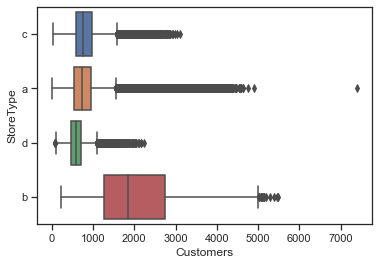

In [90]:
sns.boxplot( x = 'Customers',y = 'StoreType', data = df )

<AxesSubplot:xlabel='StoreType', ylabel='Sales'>

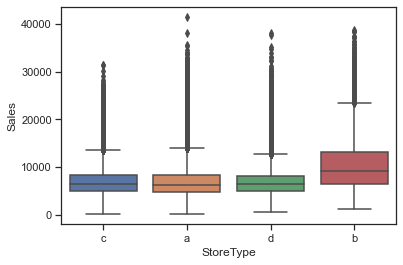

In [91]:
sns.boxplot( x = 'StoreType',y = 'Sales', data = df )

<AxesSubplot:xlabel='Sales'>

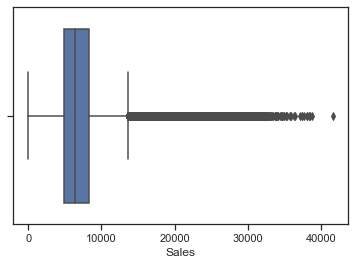

In [92]:
sns.boxplot(df['Sales'])

In [93]:
df['Sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

In [94]:
df1=df[df.Sales < df.Sales.quantile(.95)]

<AxesSubplot:xlabel='Sales'>

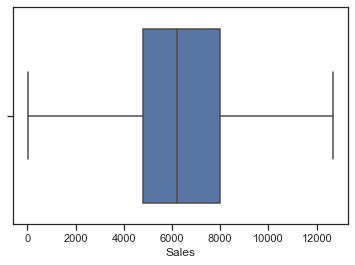

In [95]:
sns.boxplot(df1['Sales'])

In [96]:
df=df1
len(df)

802107

<AxesSubplot:xlabel='Customers'>

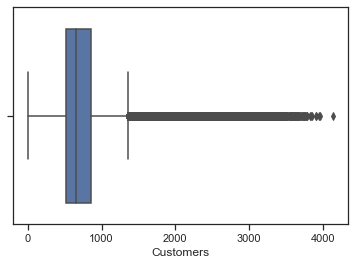

In [97]:
sns.boxplot(df['Customers'])

In [98]:
df2=df[df.Customers < df.Customers.quantile(.95)]

<AxesSubplot:xlabel='Customers'>

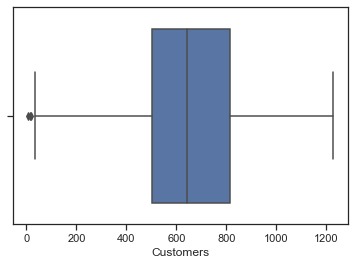

In [99]:
sns.boxplot(df2['Customers'])

In [100]:
df=df2

In [101]:
len(df)

761848

In [102]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82        0.0
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82        0.0
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82        0.0
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82        0.0
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82        0.0

In [103]:
df['CompetitionOpen'].max()

1386

Text(0.5, 1.0, 'Average Sales as per the age of the competition')

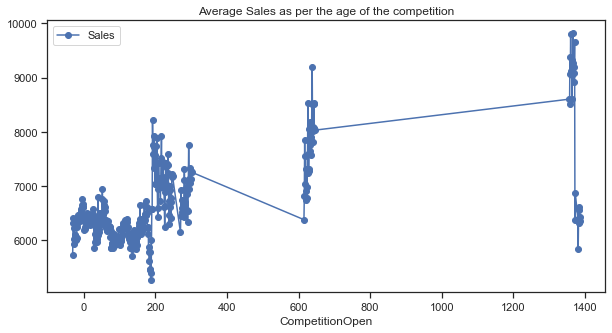

In [104]:
#Analysing CompetitionOpen column

axis = df.groupby('CompetitionOpen')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Average Sales as per the age of the competition')

Text(0.5, 1.0, 'Average Sales as per the age of the competition')

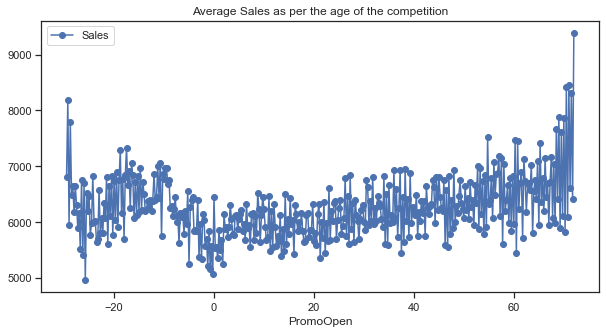

In [105]:
#Analysing PromoOpen column

axis = df.groupby('PromoOpen')[['Sales']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Average Sales as per the age of the competition')

### Time-Series Analysis per Store Type

#### Seasionality

We take four stores from store types to represent their group:

Store number 2 for StoreType A

Store number 85 for StoreType B,

Store number 1 for StoreType C

Store number 13 for StoreType D.

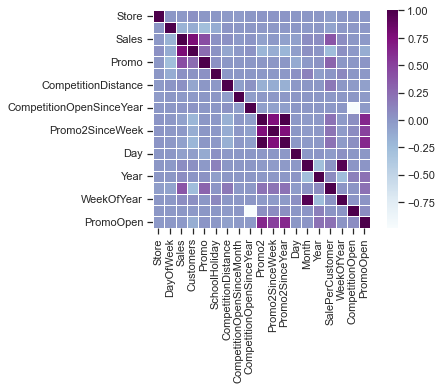

In [106]:
df_corr=df.drop('Open', axis = 1)
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = df_corr.corr()

 # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, square = True, linewidths = .5, cmap = "BuPu")      
plt.show()

In [107]:
df_corr.corr()

Store  DayOfWeek     Sales  Customers     Promo  SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear    Promo2  Promo2SinceWeek  Promo2SinceYear       Day     Month      Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
Store                      1.000000   0.000997 -0.004272   0.029569 -0.001064       0.000883            -0.023469                  -0.028970                  0.002036  0.009600         0.009934         0.009627 -0.000071  0.001611  0.002684        -0.047899    0.001572        -0.000254  -0.009795
DayOfWeek                  0.000997   1.000000 -0.182713  -0.140902 -0.270153      -0.137249             0.009742                   0.000267                  0.001734 -0.006634        -0.004565        -0.006636  0.004513 -0.014136  0.001938        -0.078005   -0.009130        -0.002198  -0.003437
Sales                     -0.004272  -0.182713  1.000000   0.777846  0.431556       0.036398             0.034797                  -0.015509                  0.008518 -0.068923        -0.012715        -0.068954 -0.063721  0.053161  0.060026         0.382037    0.055006         0.004314  -0.009809
Customers                  0.029569  -0.140902  0.777846   1.000000  0.250881       0.028452            -0.097947                  -0.014133                  0.018989 -0.199385        -0.143294        -0.199339 -0.046725  0.041751  0.012482        -0.252625    0.043614        -0.014020  -0.147800
Promo                     -0.001064  -0.270153  0.431556   0.250881  1.000000       0.029859            -0.001162                   0.002920                 -0.000889  0.005474         0.002377         0.005476 -0.125784 -0.010497  0.024012         0.295182    0.001844         0.003864   0.008846
SchoolHoliday              0.000883  -0.137249  0.036398   0.028452  0.029859       1.000000            -0.007628                   0.000122                  0.000116 -0.007226        -0.007369        -0.007229  0.032529  0.125503 -0.041435         0.012611    0.085911         0.000323  -0.005959
CompetitionDistance       -0.023469   0.009742  0.034797  -0.097947 -0.001162      -0.007628             1.000000                  -0.049583                  0.024956 -0.163236        -0.139687        -0.163300 -0.002126  0.004076 -0.001394         0.178767    0.003517        -0.022549  -0.059671
CompetitionOpenSinceMonth -0.028970   0.000267 -0.015509  -0.014133  0.002920       0.000122            -0.049583                   1.000000                 -0.047507 -0.004160        -0.004639        -0.004130 -0.000649 -0.000006 -0.000869        -0.007657   -0.000100         0.003285  -0.019962
CompetitionOpenSinceYear   0.002036   0.001734  0.008518   0.018989 -0.000889       0.000116             0.024956                  -0.047507                  1.000000 -0.049916        -0.066813        -0.049919 -0.000146  0.003846  0.001821        -0.006212    0.003734        -0.987986  -0.023284
Promo2                     0.009600  -0.006634 -0.068923  -0.199385  0.005474      -0.007226            -0.163236                  -0.004160                 -0.049916  1.000000         0.753507         0.999999 -0.001873 -0.023880 -0.005900         0.214138   -0.022884         0.047429   0.627809
Promo2SinceWeek            0.009934  -0.004565 -0.012715  -0.143294  0.002377      -0.007369            -0.139687                  -0.004639                 -0.066813  0.753507         1.000000         0.753321 -0.000929 -0.030621 -0.007458         0.205496   -0.029381         0.063583   0.498633
Promo2SinceYear            0.009627  -0.006636 -0.068954  -0.199339  0.005476      -0.007229            -0.163300                  -0.004130                 -0.049919  0.999999         0.753321         1.000000 -0.001871 -0.023884 -0.005901         0.214020   -0.022888         0.047430   0.626989
Day                       -0.000071   0.004513 -0.063721  -0.046725 -0.125784       0.032529            -0.002126                  -0.000649                

In [108]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82        0.0
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82        0.0
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82        0.0
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82        0.0
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82        0.0

In [109]:
df_Promo=df[df['Promo']==1]
df_noPromo=df[df['Promo']==0]

In [110]:
#Average sales of the store when Promo is applied

df['SalesPerPromo']=(df['Sales']*df['Promo'])/(df['Sales'].sum())

In [111]:
#df['SalesPerPromo']=(df['Sales']*df['Promo'])/(df['Sales'].sum())

In [112]:
df_bckup1=df
#df=df_Promo

df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen  SalesPerPromo
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82        0.0   1.097357e-06
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82        0.0   1.046691e-06
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82        0.0   9.970665e-07
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82        0.0   1.044814e-06
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82        0.0   1.272292e-06

In [113]:
df_assort=df[(df['Assortment'] == 'a') | (df['Assortment'] == 'b') | (df['Assortment'] == 'c')]

Text(0.5, 1.0, 'Sales Per Customer Per Assortment')

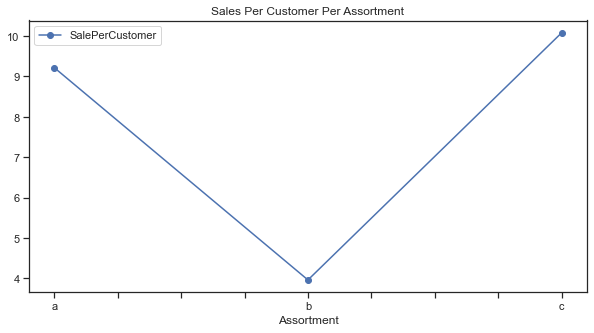

In [114]:
axis = df.groupby('Assortment')[['SalePerCustomer']].mean().plot(figsize=(10,5), marker = 'o')
axis.set_title('Sales Per Customer Per Assortment')

In [115]:
df_corr.corr()

Store  DayOfWeek     Sales  Customers     Promo  SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear    Promo2  Promo2SinceWeek  Promo2SinceYear       Day     Month      Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen
Store                      1.000000   0.000997 -0.004272   0.029569 -0.001064       0.000883            -0.023469                  -0.028970                  0.002036  0.009600         0.009934         0.009627 -0.000071  0.001611  0.002684        -0.047899    0.001572        -0.000254  -0.009795
DayOfWeek                  0.000997   1.000000 -0.182713  -0.140902 -0.270153      -0.137249             0.009742                   0.000267                  0.001734 -0.006634        -0.004565        -0.006636  0.004513 -0.014136  0.001938        -0.078005   -0.009130        -0.002198  -0.003437
Sales                     -0.004272  -0.182713  1.000000   0.777846  0.431556       0.036398             0.034797                  -0.015509                  0.008518 -0.068923        -0.012715        -0.068954 -0.063721  0.053161  0.060026         0.382037    0.055006         0.004314  -0.009809
Customers                  0.029569  -0.140902  0.777846   1.000000  0.250881       0.028452            -0.097947                  -0.014133                  0.018989 -0.199385        -0.143294        -0.199339 -0.046725  0.041751  0.012482        -0.252625    0.043614        -0.014020  -0.147800
Promo                     -0.001064  -0.270153  0.431556   0.250881  1.000000       0.029859            -0.001162                   0.002920                 -0.000889  0.005474         0.002377         0.005476 -0.125784 -0.010497  0.024012         0.295182    0.001844         0.003864   0.008846
SchoolHoliday              0.000883  -0.137249  0.036398   0.028452  0.029859       1.000000            -0.007628                   0.000122                  0.000116 -0.007226        -0.007369        -0.007229  0.032529  0.125503 -0.041435         0.012611    0.085911         0.000323  -0.005959
CompetitionDistance       -0.023469   0.009742  0.034797  -0.097947 -0.001162      -0.007628             1.000000                  -0.049583                  0.024956 -0.163236        -0.139687        -0.163300 -0.002126  0.004076 -0.001394         0.178767    0.003517        -0.022549  -0.059671
CompetitionOpenSinceMonth -0.028970   0.000267 -0.015509  -0.014133  0.002920       0.000122            -0.049583                   1.000000                 -0.047507 -0.004160        -0.004639        -0.004130 -0.000649 -0.000006 -0.000869        -0.007657   -0.000100         0.003285  -0.019962
CompetitionOpenSinceYear   0.002036   0.001734  0.008518   0.018989 -0.000889       0.000116             0.024956                  -0.047507                  1.000000 -0.049916        -0.066813        -0.049919 -0.000146  0.003846  0.001821        -0.006212    0.003734        -0.987986  -0.023284
Promo2                     0.009600  -0.006634 -0.068923  -0.199385  0.005474      -0.007226            -0.163236                  -0.004160                 -0.049916  1.000000         0.753507         0.999999 -0.001873 -0.023880 -0.005900         0.214138   -0.022884         0.047429   0.627809
Promo2SinceWeek            0.009934  -0.004565 -0.012715  -0.143294  0.002377      -0.007369            -0.139687                  -0.004639                 -0.066813  0.753507         1.000000         0.753321 -0.000929 -0.030621 -0.007458         0.205496   -0.029381         0.063583   0.498633
Promo2SinceYear            0.009627  -0.006636 -0.068954  -0.199339  0.005476      -0.007229            -0.163300                  -0.004130                 -0.049919  0.999999         0.753321         1.000000 -0.001871 -0.023884 -0.005901         0.214020   -0.022888         0.047430   0.626989
Day                       -0.000071   0.004513 -0.063721  -0.046725 -0.125784       0.032529            -0.002126                  -0.000649                

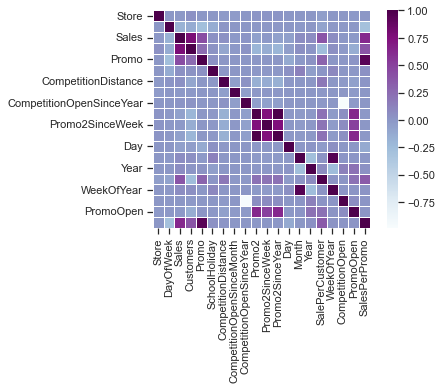

In [116]:
df_corr=df.drop('Open', axis = 1)
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = df_corr.corr()

 # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, square = True, linewidths = .5, cmap = "BuPu")      
plt.show()

### So from above the highly correlated features we can see are

SalePerCustomer,SalePerPromo



In [117]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen  SalesPerPromo
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82        0.0   1.097357e-06
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82        0.0   1.046691e-06
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82        0.0   9.970665e-07
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82        0.0   1.044814e-06
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82        0.0   1.272292e-06

In [118]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen  SalesPerPromo
0      1          5 2015-07-31   5263        555     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   31      7  2015         9.482883          31               82        0.0   1.097357e-06
1      1          4 2015-07-30   5020        546     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   30      7  2015         9.194139          31               82        0.0   1.046691e-06
2      1          3 2015-07-29   4782        523     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   29      7  2015         9.143403          31               82        0.0   9.970665e-07
3      1          2 2015-07-28   5011        560     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   28      7  2015         8.948214          31               82        0.0   1.044814e-06
4      1          1 2015-07-27   6102        612     1      1            o              1         c          a               1270.0                          9                      2008       0                0                0             0   27      7  2015         9.970588          31               82        0.0   1.272292e-06

In [119]:
df_nonscaled=df

In [120]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Sales','Customers','SalePerCustomer','CompetitionDistance','SalesPerPromo']] = scaler.fit_transform(df[['Sales','Customers','SalePerCustomer','CompetitionDistance','SalesPerPromo']])


In [121]:
df.head()

Store  DayOfWeek       Date     Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen  SalesPerPromo
0      1          5 2015-07-31  0.413359   0.449097     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   31      7  2015         0.137519          31               82        0.0       0.415489
1      1          4 2015-07-30  0.394105   0.441708     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   30      7  2015         0.131619          31               82        0.0       0.396305
2      1          3 2015-07-29  0.375248   0.422824     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   29      7  2015         0.130583          31               82        0.0       0.377516
3      1          2 2015-07-28  0.393392   0.453202     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   28      7  2015         0.126595          31               82        0.0       0.395595
4      1          1 2015-07-27  0.479835   0.495895     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   27      7  2015         0.147484          31               82        0.0       0.481724

In [122]:
df_scaled=df

In [123]:
df[df['SalesPerPromo'].isnull()]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval, Day, Month, Year, SalePerCustomer, WeekOfYear, CompetitionOpen, PromoOpen, SalesPerPromo]
Index: []

In [124]:
#df['SalesPerPromo'].fillna(0, inplace=True)

In [125]:
df2 = pd.DataFrame().assign(Store=df['Store'], Date=df['Date'], Sales=df['Sales'], Customers=df['Customers'], SalesPerCustomer=df['SalePerCustomer'],SalesPerPromo=df['SalesPerPromo'],CompetitionDistance=df['CompetitionDistance'])

In [126]:
data_span=df['Date'].max()-df['Date'].min()
data_span

Timedelta('941 days 00:00:00')

In [127]:
df2['Date'].max()

Timestamp('2015-07-31 00:00:00')

In [128]:
df2['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [129]:
df2.corr()

Store     Sales  Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
Store                1.000000 -0.004272   0.029569         -0.047899      -0.001433            -0.023469
Sales               -0.004272  1.000000   0.777846          0.382037       0.619814             0.034797
Customers            0.029569  0.777846   1.000000         -0.252625       0.391392            -0.097947
SalesPerCustomer    -0.047899  0.382037  -0.252625          1.000000       0.351637             0.178767
SalesPerPromo       -0.001433  0.619814   0.391392          0.351637       1.000000             0.012188
CompetitionDistance -0.023469  0.034797  -0.097947          0.178767       0.012188             1.000000

In [130]:
# will create a weighatge for each store such that Wt=((SalesPerCustomer)*(SalesPerPromo))*Sales

In [131]:
df_scaled.head()

Store  DayOfWeek       Date     Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen  SalesPerPromo
0      1          5 2015-07-31  0.413359   0.449097     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   31      7  2015         0.137519          31               82        0.0       0.415489
1      1          4 2015-07-30  0.394105   0.441708     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   30      7  2015         0.131619          31               82        0.0       0.396305
2      1          3 2015-07-29  0.375248   0.422824     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   29      7  2015         0.130583          31               82        0.0       0.377516
3      1          2 2015-07-28  0.393392   0.453202     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   28      7  2015         0.126595          31               82        0.0       0.395595
4      1          1 2015-07-27  0.479835   0.495895     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   27      7  2015         0.147484          31               82        0.0       0.481724

In [132]:
df_scaled['SaleWt']=df_scaled['Sales']*(df['SalePerCustomer']*df['SalesPerPromo'])

In [133]:
df_scaled.head()

Store  DayOfWeek       Date     Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen  SalesPerPromo    SaleWt
0      1          5 2015-07-31  0.413359   0.449097     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   31      7  2015         0.137519          31               82        0.0       0.415489  0.023618
1      1          4 2015-07-30  0.394105   0.441708     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   30      7  2015         0.131619          31               82        0.0       0.396305  0.020557
2      1          3 2015-07-29  0.375248   0.422824     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   29      7  2015         0.130583          31               82        0.0       0.377516  0.018499
3      1          2 2015-07-28  0.393392   0.453202     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   28      7  2015         0.126595          31               82        0.0       0.395595  0.019701
4      1          1 2015-07-27  0.479835   0.495895     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   27      7  2015         0.147484          31               82        0.0       0.481724  0.034091

In [134]:
df_scaled.head()

Store  DayOfWeek       Date     Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  SalePerCustomer  WeekOfYear  CompetitionOpen  PromoOpen  SalesPerPromo    SaleWt
0      1          5 2015-07-31  0.413359   0.449097     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   31      7  2015         0.137519          31               82        0.0       0.415489  0.023618
1      1          4 2015-07-30  0.394105   0.441708     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   30      7  2015         0.131619          31               82        0.0       0.396305  0.020557
2      1          3 2015-07-29  0.375248   0.422824     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   29      7  2015         0.130583          31               82        0.0       0.377516  0.018499
3      1          2 2015-07-28  0.393392   0.453202     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   28      7  2015         0.126595          31               82        0.0       0.395595  0.019701
4      1          1 2015-07-27  0.479835   0.495895     1      1            o              1         c          a             0.016482                          9                      2008       0                0                0             0   27      7  2015         0.147484          31               82        0.0       0.481724  0.034091

In [135]:
df_storewise_wt=df_scaled.groupby('Store')['Sales','Customers','SalePerCustomer','SalesPerPromo','SaleWt'].sum().reset_index()

In [136]:
df_storewise_wt.head()

Store       Sales   Customers  SalePerCustomer  SalesPerPromo     SaleWt
0      1  291.651058  356.547619        90.011108     146.446594   7.985064
1      2  304.872356  370.757800        90.603630     175.433331  12.028540
2      3  414.837889  464.440887        99.605321     235.926739  25.169196
3      4  164.239125  244.967159        22.800252      33.093076   2.163189
4      5  285.792251  338.551724        93.253506     168.937870  11.708050

In [137]:
df_storewise_wt.shape

(1111, 6)

In [138]:
#Average parameter values per store per day will be df_storewise_wt/941 #941 is the time span of the data set
#df_avg=df_storewise_wt[['Sales','Customers','SalePerCustomer','SalesPerPromo','SaleWt']]/942


for column in df_storewise_wt[['Sales','Customers','SalePerCustomer','SalesPerPromo','SaleWt']]:
    df_storewise_wt[column]=df_storewise_wt[column]/942

In [139]:
df_storewise_wt.head()
df_avg=df_storewise_wt

In [140]:
df_avg.head()

Store     Sales  Customers  SalePerCustomer  SalesPerPromo    SaleWt
0      1  0.309608   0.378501         0.095553       0.155463  0.008477
1      2  0.323644   0.393586         0.096182       0.186235  0.012769
2      3  0.440380   0.493037         0.105738       0.250453  0.026719
3      4  0.174352   0.260050         0.024204       0.035131  0.002296
4      5  0.303389   0.359397         0.098995       0.179340  0.012429

In [141]:
df2.set_index('Date')

Store     Sales  Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
Date                                                                                        
2015-07-31      1  0.413359   0.449097          0.137519       0.415489             0.016482
2015-07-30      1  0.394105   0.441708          0.131619       0.396305             0.016482
2015-07-29      1  0.375248   0.422824          0.130583       0.377516             0.016482
2015-07-28      1  0.393392   0.453202          0.126595       0.395595             0.016482
2015-07-27      1  0.479835   0.495895          0.147484       0.481724             0.016482
...           ...       ...        ...               ...            ...                  ...
2013-01-07   1115  0.543459   0.380131          0.243306       0.545117             0.070280
2013-01-05   1115  0.374376   0.271757          0.231321       0.000000             0.070280
2013-01-04   1115  0.356073   0.261084          0.228310       0.000000             0.070280
2013-01-03   1115  0.336820   0.239737          0.236421       0.000000             0.070280
2013-01-02   1115  0.289280   0.243842          0.191428       0.000000             0.070280

[761848 rows x 6 columns]

<AxesSubplot:>

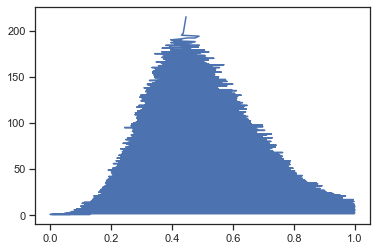

In [142]:

df_test=df2
df_test['Sales'].value_counts().sort_values().plot.line()



<AxesSubplot:>

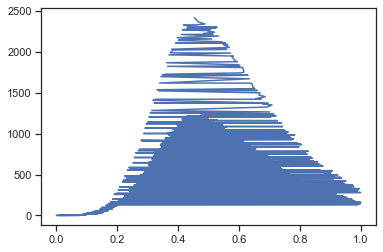

In [143]:
df_test['Customers'].value_counts().sort_values().plot.line()

In [144]:
df_test[df_test['Store']==1].shape

(781, 7)

In [145]:
df_test[df_test['Store']==3].shape

(769, 7)

In [146]:
df_test[df_test['Store']==9].shape

(777, 7)

In [147]:
df_test[df_test['Store']==13].shape

(621, 7)

In [148]:
df_test[df_test['Store']==25].shape

(69, 7)

In [149]:
df_test[df_test['Store']==29].shape

(757, 7)

In [150]:
df_test[df_test['Store']==31].shape

(783, 7)

In [151]:
df_test[df_test['Store']==46].shape

(622, 7)

In [152]:
df_test.shape

(761848, 7)

In [153]:
df_test.head()

Store       Date     Sales  Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0      1 2015-07-31  0.413359   0.449097          0.137519       0.415489             0.016482
1      1 2015-07-30  0.394105   0.441708          0.131619       0.396305             0.016482
2      1 2015-07-29  0.375248   0.422824          0.130583       0.377516             0.016482
3      1 2015-07-28  0.393392   0.453202          0.126595       0.395595             0.016482
4      1 2015-07-27  0.479835   0.495895          0.147484       0.481724             0.016482

In [154]:
df1=df_test[(df_test["Store"]==1) | (df_test["Store"]==3)]

In [155]:
df1.head()

Store       Date     Sales  Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0      1 2015-07-31  0.413359   0.449097          0.137519       0.415489             0.016482
1      1 2015-07-30  0.394105   0.441708          0.131619       0.396305             0.016482
2      1 2015-07-29  0.375248   0.422824          0.130583       0.377516             0.016482
3      1 2015-07-28  0.393392   0.453202          0.126595       0.395595             0.016482
4      1 2015-07-27  0.479835   0.495895          0.147484       0.481724             0.016482

In [156]:
df_keystores=df_test[(df_test['Store']==1) | (df_test['Store']==3) | (df_test['Store']==8) | (df_test['Store']==9) | (df_test['Store']==13) | (df_test['Store']==25) | (df_test['Store']==29) | (df_test['Store']==31) | (df_test['Store']==46)]

In [157]:
df_keystores.head()

Store       Date     Sales  Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0      1 2015-07-31  0.413359   0.449097          0.137519       0.415489             0.016482
1      1 2015-07-30  0.394105   0.441708          0.131619       0.396305             0.016482
2      1 2015-07-29  0.375248   0.422824          0.130583       0.377516             0.016482
3      1 2015-07-28  0.393392   0.453202          0.126595       0.395595             0.016482
4      1 2015-07-27  0.479835   0.495895          0.147484       0.481724             0.016482

In [158]:
df_backup2=df2

In [159]:
df2['Store']

0             1
1             1
2             1
3             1
4             1
           ... 
1017202    1115
1017204    1115
1017205    1115
1017206    1115
1017207    1115
Name: Store, Length: 761848, dtype: int64

In [160]:
df_grp_test=df2.groupby('Store')['Date','Sales','SalesPerCustomer','SalesPerPromo'].sum().reset_index()

In [161]:
df_grp_test

Store       Sales  SalesPerCustomer  SalesPerPromo
0         1  291.651058         90.011108     146.446594
1         2  304.872356         90.603630     175.433331
2         3  414.837889         99.605321     235.926739
3         4  164.239125         22.800252      33.093076
4         5  285.792251         93.253506     168.937870
...     ...         ...               ...            ...
1106   1111  321.309088        139.987728     181.756217
1107   1112  430.885112        110.971142     160.199416
1108   1113  404.653356        102.972792     208.039078
1109   1114    0.709373          0.102271       0.000000
1110   1115  387.156564        186.122723     201.024394

[1111 rows x 4 columns]

In [162]:
df_grp=df2.groupby('Store')['Sales','SalesPerCustomer','SalesPerPromo'].sum().reset_index()

In [163]:
#df_res=df_keystores.drop('Store',axis=1)

#Modelling for all 1115 stores

df_All=df2.drop('Store',axis=1)

In [164]:
#df_res.shape
df_All.shape

(761848, 6)

In [165]:
#df_res = df_res.groupby(['Date'], as_index=False)['Sales','Customers','SalesPerCustomer',"SalesPerPromo"].sum()

df_All = df_All.groupby(['Date'], as_index=False)['Sales','Customers','SalesPerCustomer',"SalesPerPromo",'CompetitionDistance'].sum()

In [166]:
df_All.head()

Date       Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0 2013-01-01    2.595278    5.448276          0.473329            0.0             0.386340
1 2013-01-02  455.547500  544.243021        126.810165            0.0            76.451938
2 2013-01-03  436.231123  523.013957        129.872202            0.0            76.916205
3 2013-01-04  464.599002  548.058292        132.711266            0.0            77.789623
4 2013-01-05  408.994374  470.109195        135.812624            0.0            77.695741

In [167]:
df_All.shape

(942, 6)

In [168]:
df_All['Sales'].min()

0.3536962205847397

In [169]:
df_All.set_index('Date')

Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
Date                                                                                    
2013-01-01    2.595278    5.448276          0.473329       0.000000             0.386340
2013-01-02  455.547500  544.243021        126.810165       0.000000            76.451938
2013-01-03  436.231123  523.013957        129.872202       0.000000            76.916205
2013-01-04  464.599002  548.058292        132.711266       0.000000            77.789623
2013-01-05  408.994374  470.109195        135.812624       0.000000            77.695741
2013-01-06    2.824737    5.202791          0.730865       0.000000             0.813555
2013-01-07  558.409635  543.424466        139.485605     559.450383            65.066719
2013-01-08  559.785120  577.049261        151.422587     561.322018            73.092761
2013-01-09  531.167340  561.804598        153.003313     532.971580            76.231474
2013-01-10  521.894145  567.614122        145.341425     523.688482            75.376648
2013-01-11  536.241185  582.276683        143.132325     537.947107            75.834718
2013-01-12  414.011726  479.026273        134.205625       0.000000            77.479101
2013-01-13    2.186752    4.026273          0.551797       0.000000             0.513713
2013-01-14  418.468426  524.940887        123.604292       0.000000            77.708795
2013-01-15  394.306315  497.044335        124.590533       0.000000            78.006263
2013-01-16  383.761033  482.017241        126.527680       0.000000            78.129285
2013-01-17  385.092782  483.144499        126.306265       0.000000            77.408953
2013-01-18  439.278504  531.743021        130.246011       0.000000            77.661326
2013-01-19  413.186435  465.969622        139.057277       0.000000            77.444422
2013-01-20    3.587196    6.749589          0.693971       0.000000             0.540480
2013-01-21  563.526583  567.971264        157.994461     565.078945            73.643921
2013-01-22  552.021710  571.195402        154.521836     553.673956            75.005076
2013-01-23  529.258854  561.276683        152.830564     531.070024            76.068631
2013-01-24  513.730449  560.314450        147.398888     515.623431            76.451147
2013-01-25  532.324935  578.387521        146.276432     534.121339            76.838674
2013-01-26  405.104191  461.487685        137.790253       0.000000            77.777360
2013-01-27    3.441486    6.441708          0.806380       0.000000             0.919568
2013-01-28  414.800650  523.743842        122.857503       0.000000            77.721849
2013-01-29  392.912923  485.433498        129.035629       0.000000            78.058610
2013-01-30  423.334601  501.959770        135.297961       0.000000            77.868737
2013-01-31  482.312178  546.454844        139.487686       0.000000            76.172798
2013-02-01  487.760082  553.676519        138.404409       0.000000            77.044106
2013-02-02  448.770541  488.375205        143.366082       0.000000            77.301490
2013-02-03    2.512479    4.636289          0.663712       0.000000             0.889504
2013-02-04  559.833611  548.147783        145.382471     561.010816            68.365572
2013-02-05  557.216385  570.956486        151.856864     558.744454            73.960377
2013-02-06  531.182949  568.567323        147.982685     532.914502            75.817576
2013-02-07  503.961810  555.468801        143.340980     505.857583            76.223695
2013-02-08  536.923857  580.989327        145.584850     538.667246            76.765361
2013-02-09  423.205847  482.707718        137.009213       0.000000            77.963278
2013-02-10    1.566199    2.753695          0.420562       0.000000             0.464267
2013-02-11  381.669202  469.247947        121.655460       0.000000            77.300831
2013-02-12  388.753823  483.102627        126.207571       0.000000            77.394185
2013-02-13  

In [170]:
df_All.set_index('Date')

Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
Date                                                                                    
2013-01-01    2.595278    5.448276          0.473329       0.000000             0.386340
2013-01-02  455.547500  544.243021        126.810165       0.000000            76.451938
2013-01-03  436.231123  523.013957        129.872202       0.000000            76.916205
2013-01-04  464.599002  548.058292        132.711266       0.000000            77.789623
2013-01-05  408.994374  470.109195        135.812624       0.000000            77.695741
2013-01-06    2.824737    5.202791          0.730865       0.000000             0.813555
2013-01-07  558.409635  543.424466        139.485605     559.450383            65.066719
2013-01-08  559.785120  577.049261        151.422587     561.322018            73.092761
2013-01-09  531.167340  561.804598        153.003313     532.971580            76.231474
2013-01-10  521.894145  567.614122        145.341425     523.688482            75.376648
2013-01-11  536.241185  582.276683        143.132325     537.947107            75.834718
2013-01-12  414.011726  479.026273        134.205625       0.000000            77.479101
2013-01-13    2.186752    4.026273          0.551797       0.000000             0.513713
2013-01-14  418.468426  524.940887        123.604292       0.000000            77.708795
2013-01-15  394.306315  497.044335        124.590533       0.000000            78.006263
2013-01-16  383.761033  482.017241        126.527680       0.000000            78.129285
2013-01-17  385.092782  483.144499        126.306265       0.000000            77.408953
2013-01-18  439.278504  531.743021        130.246011       0.000000            77.661326
2013-01-19  413.186435  465.969622        139.057277       0.000000            77.444422
2013-01-20    3.587196    6.749589          0.693971       0.000000             0.540480
2013-01-21  563.526583  567.971264        157.994461     565.078945            73.643921
2013-01-22  552.021710  571.195402        154.521836     553.673956            75.005076
2013-01-23  529.258854  561.276683        152.830564     531.070024            76.068631
2013-01-24  513.730449  560.314450        147.398888     515.623431            76.451147
2013-01-25  532.324935  578.387521        146.276432     534.121339            76.838674
2013-01-26  405.104191  461.487685        137.790253       0.000000            77.777360
2013-01-27    3.441486    6.441708          0.806380       0.000000             0.919568
2013-01-28  414.800650  523.743842        122.857503       0.000000            77.721849
2013-01-29  392.912923  485.433498        129.035629       0.000000            78.058610
2013-01-30  423.334601  501.959770        135.297961       0.000000            77.868737
2013-01-31  482.312178  546.454844        139.487686       0.000000            76.172798
2013-02-01  487.760082  553.676519        138.404409       0.000000            77.044106
2013-02-02  448.770541  488.375205        143.366082       0.000000            77.301490
2013-02-03    2.512479    4.636289          0.663712       0.000000             0.889504
2013-02-04  559.833611  548.147783        145.382471     561.010816            68.365572
2013-02-05  557.216385  570.956486        151.856864     558.744454            73.960377
2013-02-06  531.182949  568.567323        147.982685     532.914502            75.817576
2013-02-07  503.961810  555.468801        143.340980     505.857583            76.223695
2013-02-08  536.923857  580.989327        145.584850     538.667246            76.765361
2013-02-09  423.205847  482.707718        137.009213       0.000000            77.963278
2013-02-10    1.566199    2.753695          0.420562       0.000000             0.464267
2013-02-11  381.669202  469.247947        121.655460       0.000000            77.300831
2013-02-12  388.753823  483.102627        126.207571       0.000000            77.394185
2013-02-13  

In [171]:
df_All.head()

Date       Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0 2013-01-01    2.595278    5.448276          0.473329            0.0             0.386340
1 2013-01-02  455.547500  544.243021        126.810165            0.0            76.451938
2 2013-01-03  436.231123  523.013957        129.872202            0.0            76.916205
3 2013-01-04  464.599002  548.058292        132.711266            0.0            77.789623
4 2013-01-05  408.994374  470.109195        135.812624            0.0            77.695741

In [172]:

# to set the plot size
plt.figure(figsize=(16, 8), dpi=1000)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df_All['Customers'].plot(label='Customers', color='orange')

# adding title to the plot
plt.title('Customers')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

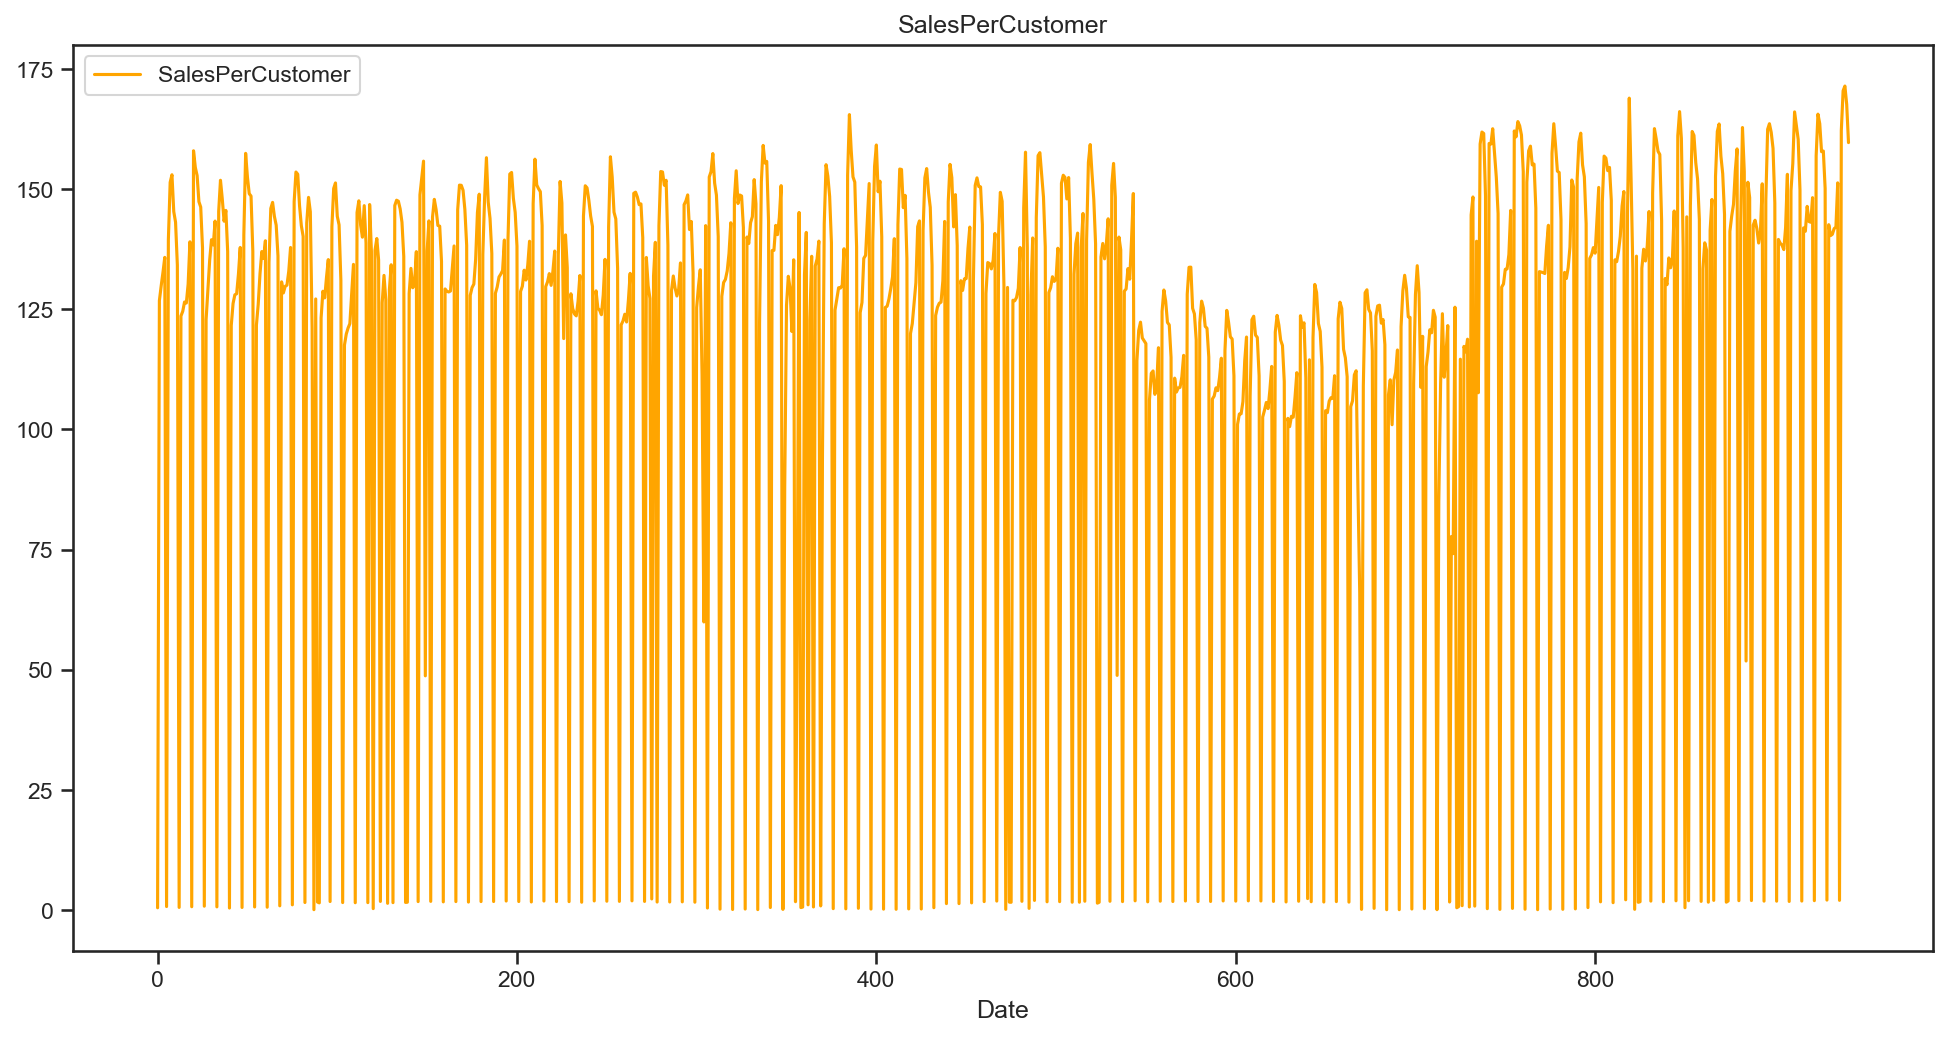

In [173]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df_All['SalesPerCustomer'].plot(label='SalesPerCustomer', color='orange')

# adding title to the plot
plt.title('SalesPerCustomer')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

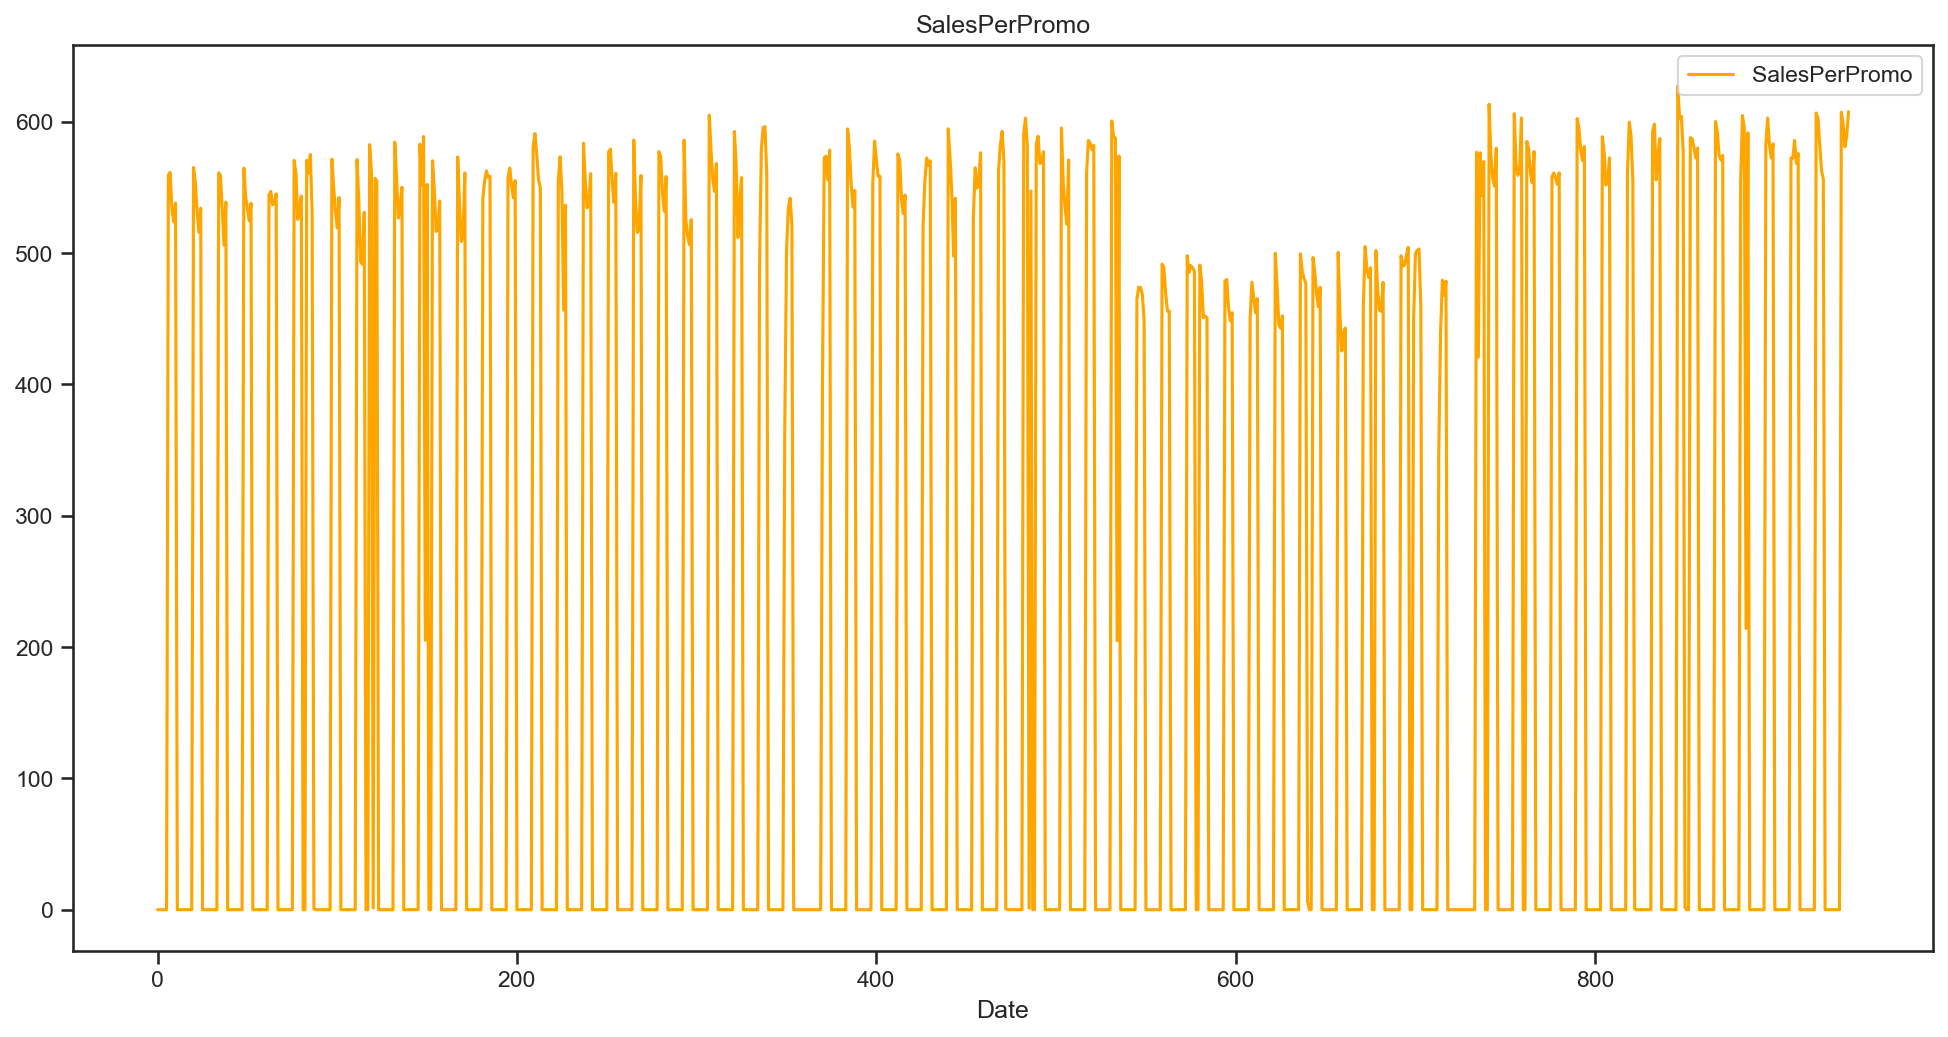

In [174]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df_All['SalesPerPromo'].plot(label='SalesPerPromo', color='orange')

# adding title to the plot
plt.title('SalesPerPromo')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

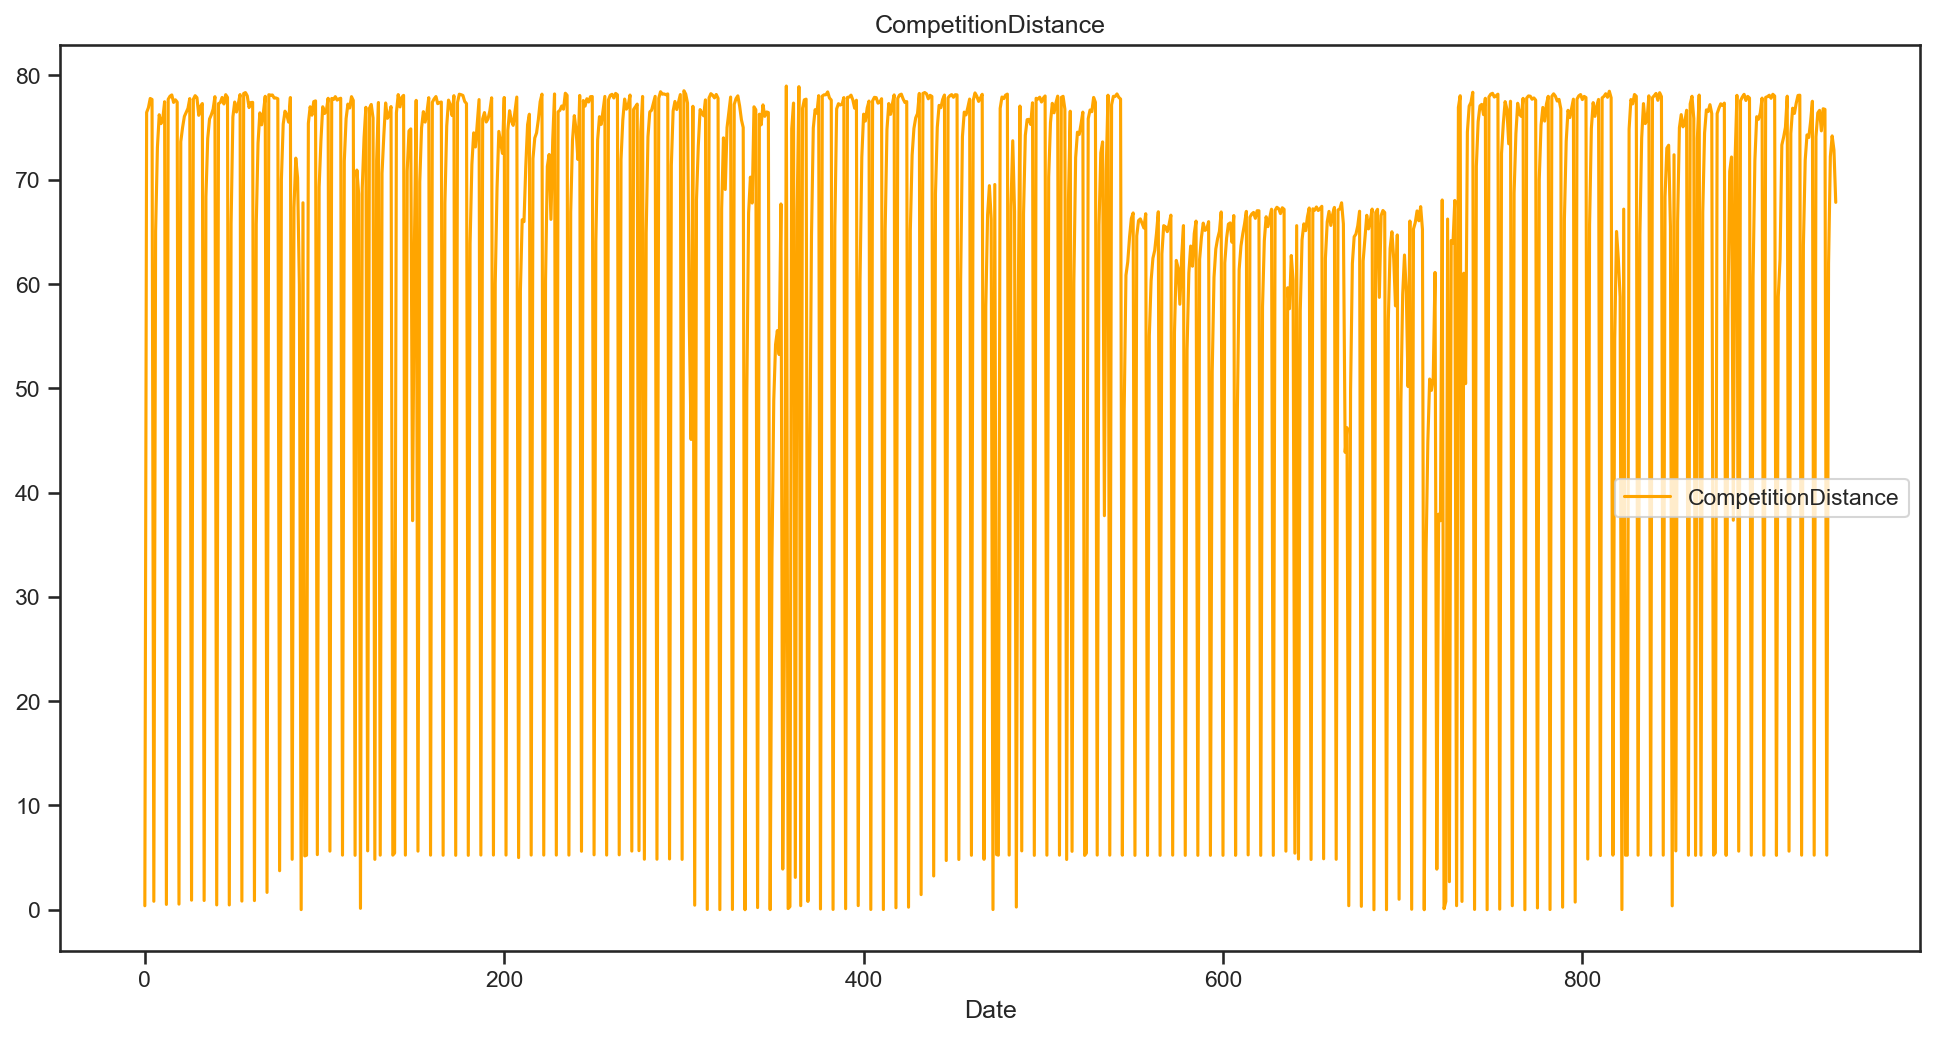

In [175]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df_All['CompetitionDistance'].plot(label='CompetitionDistance', color='orange')

# adding title to the plot
plt.title('CompetitionDistance')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

### Stationarity ADF test 

In [176]:
df_All['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [177]:
df_All['Date'].max()

Timestamp('2015-07-31 00:00:00')

In [178]:
df_All.head()

Date       Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0 2013-01-01    2.595278    5.448276          0.473329            0.0             0.386340
1 2013-01-02  455.547500  544.243021        126.810165            0.0            76.451938
2 2013-01-03  436.231123  523.013957        129.872202            0.0            76.916205
3 2013-01-04  464.599002  548.058292        132.711266            0.0            77.789623
4 2013-01-05  408.994374  470.109195        135.812624            0.0            77.695741

In [179]:
len(df_All)

942

In [180]:
train_len = 900
train = df_All[0:train_len] # first 900 days as training set
test = df_All[train_len:] # last 6 weeks(42 days) as test set

#To convert raw data to first difference of ln use: np.log(dta['inv']).diff()


In [181]:
train.head()

Date       Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0 2013-01-01    2.595278    5.448276          0.473329            0.0             0.386340
1 2013-01-02  455.547500  544.243021        126.810165            0.0            76.451938
2 2013-01-03  436.231123  523.013957        129.872202            0.0            76.916205
3 2013-01-04  464.599002  548.058292        132.711266            0.0            77.789623
4 2013-01-05  408.994374  470.109195        135.812624            0.0            77.695741

In [182]:
train.set_index('Date')

Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
Date                                                                                    
2013-01-01    2.595278    5.448276          0.473329       0.000000             0.386340
2013-01-02  455.547500  544.243021        126.810165       0.000000            76.451938
2013-01-03  436.231123  523.013957        129.872202       0.000000            76.916205
2013-01-04  464.599002  548.058292        132.711266       0.000000            77.789623
2013-01-05  408.994374  470.109195        135.812624       0.000000            77.695741
2013-01-06    2.824737    5.202791          0.730865       0.000000             0.813555
2013-01-07  558.409635  543.424466        139.485605     559.450383            65.066719
2013-01-08  559.785120  577.049261        151.422587     561.322018            73.092761
2013-01-09  531.167340  561.804598        153.003313     532.971580            76.231474
2013-01-10  521.894145  567.614122        145.341425     523.688482            75.376648
2013-01-11  536.241185  582.276683        143.132325     537.947107            75.834718
2013-01-12  414.011726  479.026273        134.205625       0.000000            77.479101
2013-01-13    2.186752    4.026273          0.551797       0.000000             0.513713
2013-01-14  418.468426  524.940887        123.604292       0.000000            77.708795
2013-01-15  394.306315  497.044335        124.590533       0.000000            78.006263
2013-01-16  383.761033  482.017241        126.527680       0.000000            78.129285
2013-01-17  385.092782  483.144499        126.306265       0.000000            77.408953
2013-01-18  439.278504  531.743021        130.246011       0.000000            77.661326
2013-01-19  413.186435  465.969622        139.057277       0.000000            77.444422
2013-01-20    3.587196    6.749589          0.693971       0.000000             0.540480
2013-01-21  563.526583  567.971264        157.994461     565.078945            73.643921
2013-01-22  552.021710  571.195402        154.521836     553.673956            75.005076
2013-01-23  529.258854  561.276683        152.830564     531.070024            76.068631
2013-01-24  513.730449  560.314450        147.398888     515.623431            76.451147
2013-01-25  532.324935  578.387521        146.276432     534.121339            76.838674
2013-01-26  405.104191  461.487685        137.790253       0.000000            77.777360
2013-01-27    3.441486    6.441708          0.806380       0.000000             0.919568
2013-01-28  414.800650  523.743842        122.857503       0.000000            77.721849
2013-01-29  392.912923  485.433498        129.035629       0.000000            78.058610
2013-01-30  423.334601  501.959770        135.297961       0.000000            77.868737
2013-01-31  482.312178  546.454844        139.487686       0.000000            76.172798
2013-02-01  487.760082  553.676519        138.404409       0.000000            77.044106
2013-02-02  448.770541  488.375205        143.366082       0.000000            77.301490
2013-02-03    2.512479    4.636289          0.663712       0.000000             0.889504
2013-02-04  559.833611  548.147783        145.382471     561.010816            68.365572
2013-02-05  557.216385  570.956486        151.856864     558.744454            73.960377
2013-02-06  531.182949  568.567323        147.982685     532.914502            75.817576
2013-02-07  503.961810  555.468801        143.340980     505.857583            76.223695
2013-02-08  536.923857  580.989327        145.584850     538.667246            76.765361
2013-02-09  423.205847  482.707718        137.009213       0.000000            77.963278
2013-02-10    1.566199    2.753695          0.420562       0.000000             0.464267
2013-02-11  381.669202  469.247947        121.655460       0.000000            77.300831
2013-02-12  388.753823  483.102627        126.207571       0.000000            77.394185
2013-02-13  

In [183]:
#train.index = train.to_datetime(train.index)
#train['Date'] = pd.to_datetime(train['Date'])
#train['Date'].resample('W')

In [184]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 900 non-null    datetime64[ns]
 1   Sales                900 non-null    float64       
 2   Customers            900 non-null    float64       
 3   SalesPerCustomer     900 non-null    float64       
 4   SalesPerPromo        900 non-null    float64       
 5   CompetitionDistance  900 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 42.3 KB


In [185]:
train.iloc[898] #last element of the train dataset

Date                   2015-06-18 00:00:00
Sales                           570.632993
Customers                       583.412972
SalesPerCustomer                161.809881
SalesPerPromo                   572.348386
CompetitionDistance              75.789623
Name: 898, dtype: object

In [186]:
df_All[df_All['Date']=='2015-06-01']

Date       Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
881 2015-06-01  553.674986  507.950739        143.082564     554.562248            57.387065

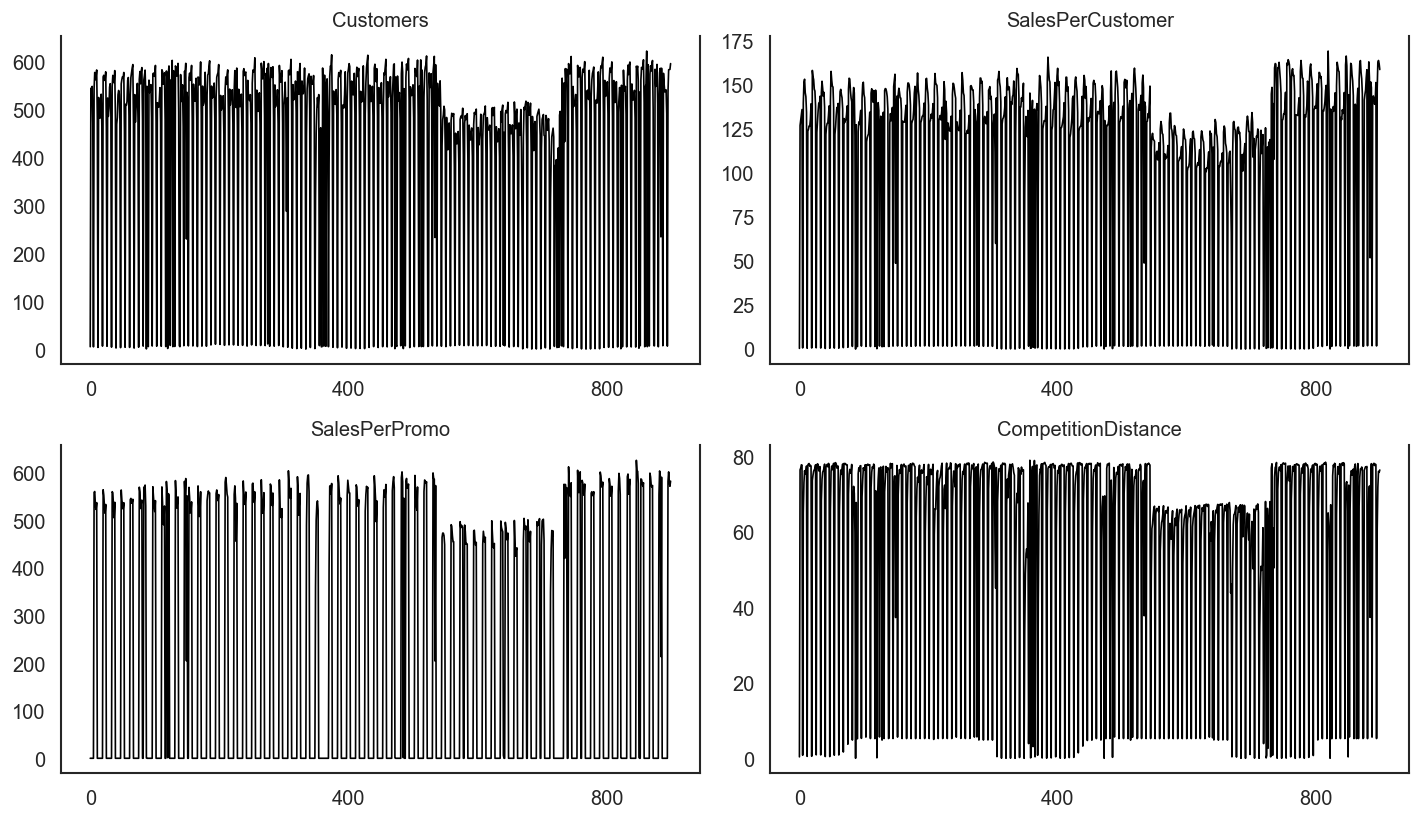

In [187]:
# Plot
ls=['Customers','SalesPerCustomer','SalesPerPromo','CompetitionDistance']
#df=train[ls]
ls=['Customers','SalesPerCustomer','SalesPerPromo','CompetitionDistance']
df_plt=train[ls]
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df_plt[df_plt.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df_plt.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [188]:
train.head()

Date       Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0 2013-01-01    2.595278    5.448276          0.473329            0.0             0.386340
1 2013-01-02  455.547500  544.243021        126.810165            0.0            76.451938
2 2013-01-03  436.231123  523.013957        129.872202            0.0            76.916205
3 2013-01-04  464.599002  548.058292        132.711266            0.0            77.789623
4 2013-01-05  408.994374  470.109195        135.812624            0.0            77.695741

In [189]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [190]:
adfuller_test(train['SalesPerCustomer'])

ADF Test Statistic : -4.020564799009087
p-value : 0.0013065745859860377
#Lags Used : 21
Number of Observations Used : 878
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [191]:
adfuller_test(train['SalesPerPromo'])

ADF Test Statistic : -7.622563797821122
p-value : 2.109477252404444e-11
#Lags Used : 21
Number of Observations Used : 878
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [192]:
adfuller_test(train['CompetitionDistance'])

ADF Test Statistic : -4.4330268844099825
p-value : 0.0002593330781997177
#Lags Used : 21
Number of Observations Used : 878
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [193]:
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Customers: ADF test results:
ADF Statistic: -4.377824
p-value: 0.000325
Critical Values:
	5%: -2.865


SalesPerCustomer: ADF test results:
ADF Statistic: -4.020565
p-value: 0.001307
Critical Values:
	5%: -2.865


SalesPerPromo: ADF test results:
ADF Statistic: -7.622564
p-value: 0.000000
Critical Values:
	5%: -2.865


CompetitionDistance: ADF test results:
ADF Statistic: -4.433027
p-value: 0.000259
Critical Values:
	5%: -2.865


In [194]:
#Var Model a basic model with lag 1

exog = train['CompetitionDistance']
mod_VAR = sm.tsa.VARMAX(train[['SalesPerCustomer','SalesPerPromo']], order=(1,0), trend='n')
res_VAR = mod_VAR.fit(maxiter=1000, disp=False)
print(res_VAR.summary())
#Note the AIC value - lower AIC => better model

                                     Statespace Model Results                                    
Dep. Variable:     ['SalesPerCustomer', 'SalesPerPromo']   No. Observations:                  900
Model:                                            VAR(1)   Log Likelihood              -11049.248
Date:                                   Tue, 18 Oct 2022   AIC                          22112.496
Time:                                           23:08:20   BIC                          22146.113
Sample:                                                0   HQIC                         22125.338
                                                   - 900                                         
Covariance Type:                                     opg                                         
Ljung-Box (L1) (Q):           131.68, 0.07   Jarque-Bera (JB):          2.02, 43.05
Prob(Q):                        0.00, 0.79   Prob(JB):                   0.36, 0.00
Heteroskedasticity (H):         0.98, 0.93   Ske

In [195]:
#Choosing a suitable lag value

for i in [1,2,3,4,5,6]:
    exog = train['CompetitionDistance']
    mod_VAR = sm.tsa.VARMAX(train[['SalesPerCustomer','SalesPerPromo']], order=(i,0), trend='n')
    res_VAR = mod_VAR.fit(maxiter=1000, disp=False)
    print("AIC for lag ",i," is:",res_VAR.aic)

AIC for lag  1  is: 22112.496374860813
AIC for lag  2  is: 21599.01119360386
AIC for lag  3  is: 21373.63405925798
AIC for lag  4  is: 21243.15576655783
AIC for lag  5  is: 21028.854423809444
AIC for lag  6  is: 20597.13418168298


In [196]:
#Var Model for lag 10

exog = train['CompetitionDistance']
mod_VAR = sm.tsa.VARMAX(train[['SalesPerCustomer','SalesPerPromo']], order=(10,0), trend='n')
res_VAR = mod_VAR.fit(maxiter=1000, disp=False)
#print(res.summary())
print(res_VAR.aic)

19523.559846164113


In [197]:
#The above AIC value is lesser than the initial lags, to avoid overfitting considering lag value as 10

In [198]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [199]:
start_index = test.index.min()
end_index = test.index.max()
predictions = mod_VAR.fit().predict(start=start_index, end=end_index)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.SalesPerCustomer, predictions.SalesPerCustomer)).round(2)
#print('SalesPerCustomer: RMSE:',  rmse)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='SalesPerCustomer'
model_comparison.loc[0,'RMSE']=rmse

rmse = np.sqrt(mean_squared_error(test.SalesPerPromo, predictions.SalesPerPromo)).round(2)
#print('SalesPerPromo: RMSE:',  rmse)

append=pd.DataFrame()
append.loc[0,'Model']='VAR'
append.loc[0,'Variable']='SalesPerPromo'
append.loc[0,'RMSE']=rmse

model_comparison = model_comparison.append(append)

# Mean Absolute Percentage Error
abs_error = np.abs(test.SalesPerCustomer-predictions.SalesPerCustomer)
actual = test.SalesPerCustomer
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('SalesPerCustomer: MAPE:',  mape)

model_comparison.loc[model_comparison['Variable']=='SalesPerCustomer', 'MAPE'] = mape

abs_error = np.abs(test.SalesPerPromo-predictions.SalesPerPromo)
actual = test.SalesPerPromo
mape = np.round(np.mean(abs_error/actual)*100, 2)
#print('SalesPerPromo: MAPE:',  mape)

model_comparison.loc[model_comparison['Variable']=='SalesPerPromo', 'MAPE'] = mape

In [200]:
model_comparison.reset_index(drop=True, inplace=True)
model_comparison

Model          Variable    RMSE    MAPE
0   VAR  SalesPerCustomer   23.52  335.51
1   VAR     SalesPerPromo  176.63     inf

#### Johannsen Test 

In [201]:
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [202]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
df_dt=train.drop('Date',axis=1)

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_dt)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  556.75    > 60.0627   =>   True
Customers ::  263.47    > 40.1749   =>   True
SalesPerCustomer ::  97.22     > 24.2761   =>   True
SalesPerPromo ::  35.56     > 12.3212   =>   True
CompetitionDistance ::  1.01      > 4.1296    =>   False


In [203]:
#From the above results we conclude that all the features except CompetitionDistance are cointegrated

#### VARMAX Model 

In [204]:
#Choosing an optimum value for MA parameter with lag value 10
for i in [1,2,3,4,5]:
    exog = train['CompetitionDistance']
    mod_VARM = sm.tsa.VARMAX(train[['SalesPerCustomer', 'SalesPerPromo']], order=(10,i), trend='n', exog=exog)
    res_VARM = mod_VARM.fit(maxiter=1000, disp=False)
    #print(res.summary())
    print(res_VARM.aic)

17226.103668920787
17163.35240468004
17162.578012787628
17166.477914152423
17165.735390872927


In [205]:
#Checking for optimum models with lag value 1
for i in [1,2,3,4,5]:
    exog = train['CompetitionDistance']
    mod_VARM = sm.tsa.VARMAX(train[['SalesPerCustomer', 'SalesPerPromo']], order=(1,i), trend='n', exog=exog)
    res_VARM = mod_VARM.fit(maxiter=1000, disp=False)
    #print(res.summary())
    print(res_VARM.aic)

19420.763627544333
18374.537419579472
18269.553895900543
18115.33628056537
17929.703581306


In [206]:
#Checking for optimum models with lag value 5
for i in [1,2,3,4,5,6,7,8,9,10]:
    exog = train['CompetitionDistance']
    mod_VARM = sm.tsa.VARMAX(train[['SalesPerCustomer', 'SalesPerPromo']], order=(5,i), trend='n', exog=exog)
    res_VARM = mod_VARM.fit(maxiter=1000, disp=False)
    #print(res.summary())
    print(res_VARM.aic)

17766.812146101445
17675.204395794597
17611.75602224527
17702.612435011684
17755.661455888163


KeyboardInterrupt: 

In [207]:
exog = train['CompetitionDistance']
mod_VARM = sm.tsa.VARMAX(train[['SalesPerCustomer', 'SalesPerPromo']], order=(10,3), trend='n', exog=exog)
res_VARM = mod_VARM.fit(maxiter=1000, disp=False)
print(res_VARM.summary())

                                     Statespace Model Results                                    
Dep. Variable:     ['SalesPerCustomer', 'SalesPerPromo']   No. Observations:                  900
Model:                                      VARMAX(10,3)   Log Likelihood               -8524.289
Date:                                   Tue, 18 Oct 2022   AIC                          17162.578
Time:                                           23:48:37   BIC                          17436.315
Sample:                                                0   HQIC                         17267.147
                                                   - 900                                         
Covariance Type:                                     opg                                         
Ljung-Box (L1) (Q):             1.01, 0.35   Jarque-Bera (JB):    9698.96, 39341.48
Prob(Q):                        0.31, 0.55   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.92, 0.72   Ske

In [208]:
start_index = test.index.min()
end_index = test.index.max()
exog = test['CompetitionDistance']
predictions = mod_VARM.fit().predict(start=start_index, end=end_index,exog=exog)


# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.SalesPerCustomer, predictions.SalesPerCustomer)).round(2)

model_comparison1=pd.DataFrame()
model_comparison1.loc[0,'Model']='VARMAX'
model_comparison1.loc[0,'Variable']='SalesPerCustomer'
model_comparison1.loc[0,'RMSE']=rmse
#print('SalesPerCustomer: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test.SalesPerPromo, predictions.SalesPerPromo)).round(2)

append=pd.DataFrame()
append.loc[0,'Model']='VARMAX'
append.loc[0,'Variable']='SalesPerPromo'
append.loc[0,'RMSE']=rmse

model_comparison1=model_comparison1.append(append)
#print('SalesPerPromo: RMSE:',  rmse)

# Mean Absolute Percentage Error
abs_error = np.abs(test.SalesPerCustomer-predictions.SalesPerCustomer)
actual = test.SalesPerCustomer
mape = np.round(np.mean(abs_error/actual)*100, 2)

model_comparison1.loc[model_comparison1['Variable']=='SalesPerCustomer', 'MAPE'] = mape

#print('SalesPerCustomer: MAPE:',  mape)
abs_error = np.abs(test.SalesPerPromo-predictions.SalesPerPromo)
actual = test.SalesPerPromo
mape = np.round(np.mean(abs_error/actual)*100, 2)

model_comparison1.loc[model_comparison1['Variable']=='SalesPerPromo', 'MAPE'] = mape
#print('SalesPerPromo: MAPE:',  mape)
model_comparison.append(model_comparison1)

Model          Variable    RMSE    MAPE
0     VAR  SalesPerCustomer   23.52  335.51
1     VAR     SalesPerPromo  176.63     inf
0  VARMAX  SalesPerCustomer   17.58   58.98
0  VARMAX     SalesPerPromo  206.71     inf

In [210]:
#From the above results VARMAX model is suited better for forecasting, 
#thus will be using VARMAX model to forecast
#Note that MAPE values for SalesForPromo is shown as inf because those values are very close to zero 
#thus making it inf

#### Forecasting using the VARMAX Model
Here we will be forecasting for next 6 weeks i.e. 42 Days
First we will assign Sales weightage to each store across the train set 
Then we will predict the sales for the 9 key stores mentioned in the problem

In [211]:
#print(res.forecast(42))

forecast_VARM=res_VARM.forecast(42,exog=test['CompetitionDistance'])

In [212]:
forecast_VARM

SalesPerCustomer  SalesPerPromo
900        144.618530      70.715647
901          6.186137      25.767015
902        137.532225     170.781991
903        134.749796     115.055574
904        134.237679      66.548054
905        134.070658      94.291874
906        137.982360      87.079852
907        142.737792      -4.622239
908          9.092557      36.462335
909        125.887858     408.310843
910        129.904843     447.613068
911        149.248198     523.955770
912        145.247444     467.705631
913        144.489062     415.404525
914        139.895056      59.006802
915          1.925132     -28.856313
916        134.043049     137.343329
917        134.670355     114.684158
918        132.372151     106.727617
919        135.491586     142.887800
920        140.518639     167.087856
921        142.762912      27.126101
922         10.460892      89.874679
923        133.375165     424.614462
924        144.804490     431.416339
925        146.598755     459.054399
926        141.280380     414.364362
927        142.007127     345.207892
928        138.375186      31.913057
929          0.880953     -33.066783
930        136.343626     192.314219
931        137.077974     158.431101
932        136.068816     156.791259
933        132.844073     178.060995
934        140.607450     209.669767
935        140.441461      28.377224
936         10.171497      91.380051
937        127.728709     395.382359
938        143.964757     411.177324
939        144.175734     409.080856
940        137.610606     377.205084
941        126.796047     301.120076

#### Regenerating the original dataframe based on forecasted values 

In [213]:
df_All.head()

Date       Sales   Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0 2013-01-01    2.595278    5.448276          0.473329            0.0             0.386340
1 2013-01-02  455.547500  544.243021        126.810165            0.0            76.451938
2 2013-01-03  436.231123  523.013957        129.872202            0.0            76.916205
3 2013-01-04  464.599002  548.058292        132.711266            0.0            77.789623
4 2013-01-05  408.994374  470.109195        135.812624            0.0            77.695741

In [214]:
max_date=df_All['Date'].max()

In [215]:
max_date

Timestamp('2015-07-31 00:00:00')

In [216]:
from datetime import datetime, date, timedelta


In [217]:
start_date=max_date + timedelta(days=1)

In [218]:
start_date

Timestamp('2015-08-01 00:00:00')

In [219]:
end_date=start_date + timedelta(days=41)

In [220]:
end_date

Timestamp('2015-09-11 00:00:00')

In [221]:
df_forecast=forecast_VAR

NameError: name 'forecast_VAR' is not defined

In [222]:
df_forecast['Date']=pd.date_range(start=start_date,end=end_date,freq='D')

NameError: name 'df_forecast' is not defined

In [223]:
df_forecast.set_index('Date')

NameError: name 'df_forecast' is not defined

In [224]:
def forecastSales(storenum,df_forecast,df_avg):
    start_date=df_forecast['Date'].min()
    end_date=df_forecast['Date'].max()
    delta = datetime.timedelta(days=1)
    store_detail=df_avg[df_avg['Store']==storenum]
    while start_date <= end_date:
        print("The Sales forecast for the date ",start_date,"is:",store_detail['SaleWt']/(df_forecast['SalePerCustomer']*(df_forecast['SalesPerPromo']))
        start_date += delta
        

SyntaxError: invalid syntax (Temp/ipykernel_18484/2035049717.py, line 8)

In [225]:
df2.head()

Store       Date     Sales  Customers  SalesPerCustomer  SalesPerPromo  CompetitionDistance
0      1 2015-07-31  0.413359   0.449097          0.137519       0.415489             0.016482
1      1 2015-07-30  0.394105   0.441708          0.131619       0.396305             0.016482
2      1 2015-07-29  0.375248   0.422824          0.130583       0.377516             0.016482
3      1 2015-07-28  0.393392   0.453202          0.126595       0.395595             0.016482
4      1 2015-07-27  0.479835   0.495895          0.147484       0.481724             0.016482

In [226]:
#finding min and max values for SalesPerCustomer and SalesPerPromo
SalesPerCustomer_min=df_nonscaled['SalesPerCustomer'].min()
alesPerCustomer_max=df_nonscaled['SalesPerCustomer'].max()
SalesPerPromo_min=df_nonscaled['SalesPerPromo'].min()
alesPerPromo_max=df_nonscaled['SalesPerPromo'].max()


KeyError: 'SalesPerCustomer'

Due to time crunch actual sales forecast could not be found 

Although have tried some functions to forecast the Sales
The logic of finding the actual Sales is as under:

Sales-Average*SalesPerCustomer-Average*SalesPerPromo-Average = Sales-Forecasted*SalesPerCUstomer-Forecasted*SalesPerPromo-Forecasted

Average values we will get from df_avg
Forecasted values we will get from df_forecast

Once we will get the Sales-Forecasted value we will have to rescale it to get the actual Sales value of a particular store on a particular day

The Result Summary:

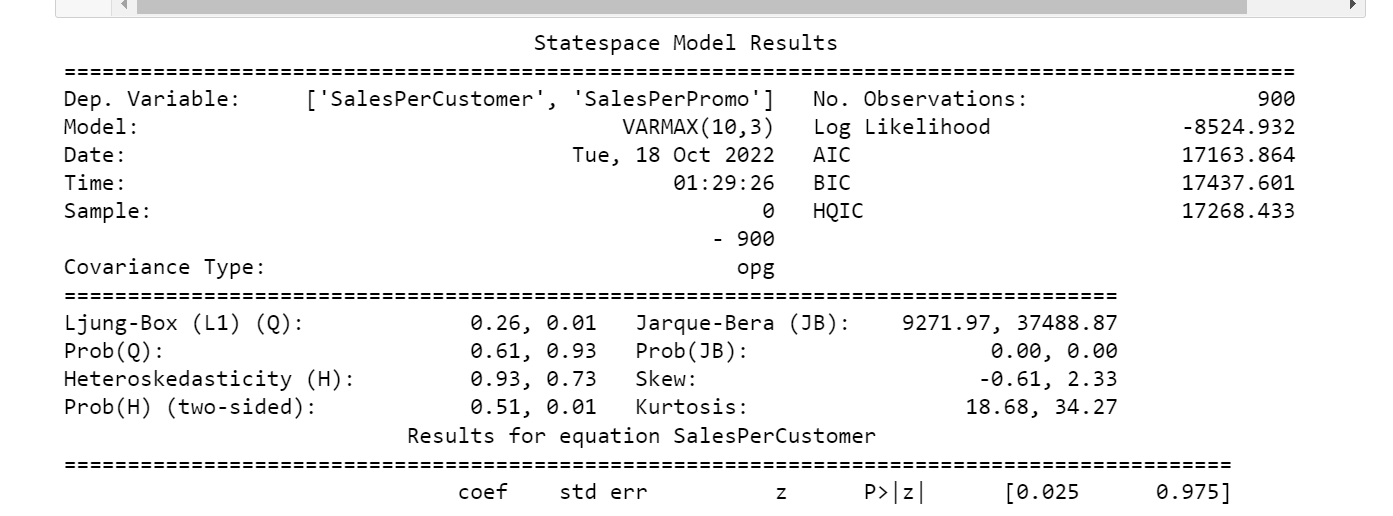

VAR and VARMAX results comparison

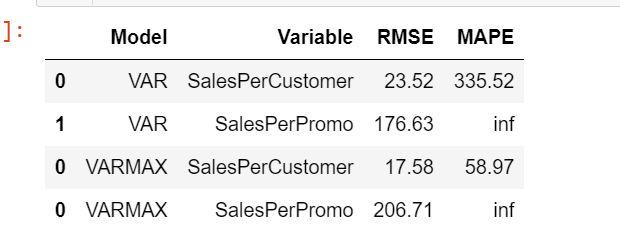

From the results shown VARMAX is chosen for forecasting